In [ ]:
!pip install kagglehub

In [ ]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
import os
import urllib.request
import bz2
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
import zipfile
import shutil
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ============================================================================
# STEP 1: MODEL DOWNLOAD & SETUP
# ============================================================================

print("\n" + "="*80)
print("STEP 1: MODEL DOWNLOAD & SETUP")
print("="*80)

FACE_PROTO = "deploy.prototxt"
FACE_MODEL = "res10_300x300_ssd_iter_140000.caffemodel"

if not os.path.exists(FACE_PROTO):
    print("📥 Downloading face detection model...")
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt",
        FACE_PROTO
    )

if not os.path.exists(FACE_MODEL):
    print("📥 Downloading face detection weights...")
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel",
        FACE_MODEL
    )

LANDMARK_MODEL = "shape_predictor_68_face_landmarks.dat"
if not os.path.exists(LANDMARK_MODEL):
    print("📥 Downloading facial landmark model...")
    urllib.request.urlretrieve(
        "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2",
        "shape_predictor_68_face_landmarks.dat.bz2"
    )
    print("🔧 Extracting landmark model...")
    with bz2.open("shape_predictor_68_face_landmarks.dat.bz2") as f:
        with open(LANDMARK_MODEL, 'wb') as out:
            out.write(f.read())

face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
landmark_predictor = dlib.shape_predictor(LANDMARK_MODEL)
print("✅ Models loaded successfully\n")

# ============================================================================
# STEP 2: DATASET SETUP & VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("STEP 2: DATASET SETUP & VISUALIZATION")
print("="*80)

DATASET_DIR = Path("/content/facial_palsy_dataset")
NORMAL_DIR = DATASET_DIR / "normal"
NORMAL_DIR.mkdir(parents=True, exist_ok=True)

# Define the Google Drive paths
DRIVE_PATHS = [
    "/content/drive/MyDrive/palsy project/Eye.zip",
    "/content/drive/MyDrive/palsy project/Eyebrow.zip",
    "/content/drive/MyDrive/palsy project/Mouth.zip"
]

# Enhanced class mapping
SEVERITY_TO_CLASS = {
    'Normal': 0,
    'Mild': 1,
    'Moderate': 2,
    'Moderate severe': 3,
    'Severe': 3
}

CLASS_NAMES = ['Normal', 'Palsy_Mild', 'Palsy_Moderate', 'Palsy_Severe']
CLASS_COLORS = ['#2E8B57', '#FFD700', '#FF8C00', '#DC143C']  # Green, Yellow, Orange, Red

print("\n📦 Processing Google Drive ZIP files...")
temp_extract_dirs = []

for idx, zip_path in enumerate(DRIVE_PATHS, 1):
    zip_file = Path(zip_path)

    if zip_file.exists():
        print(f"  ✅ Found: {zip_file.name}")
        temp_extract_dir = DATASET_DIR / f"temp_extract_{idx}"
        temp_extract_dir.mkdir(exist_ok=True)
        temp_extract_dirs.append(temp_extract_dir)

        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(temp_extract_dir)
            print(f"  ✅ Extracted: {zip_file.name}")
        except Exception as e:
            print(f"  ❌ Failed to extract {zip_file.name}: {e}")
    else:
        print(f"  ❌ Not found: {zip_path}")

collected_images = defaultdict(lambda: defaultdict(list))
image_labels = {}

print("\n🔍 Scanning extracted directories for images...")

for extract_idx, temp_extract_dir in enumerate(temp_extract_dirs, 1):
    print(f"\n📁 Processing extraction directory {extract_idx}...")

    for category in ['Eye', 'Eyebrow', 'Mouth']:
        category_found = False

        for dirpath in temp_extract_dir.rglob("*"):
            if dirpath.is_dir() and dirpath.name.lower() == category.lower():
                category_found = True
                print(f"  📂 Found {category} directory: {dirpath}")

                search_path = dirpath / category if (dirpath / category).exists() else dirpath

                severity_dirs = [d for d in search_path.iterdir() if d.is_dir()]
                print(f"    Found {len(severity_dirs)} severity directories")

                for severity_dir in severity_dirs:
                    severity_name = severity_dir.name

                    for suffix in [f' {category.lower()}', f'_{category.lower()}']:
                        if suffix in severity_name.lower():
                            severity_name = severity_name.replace(suffix, '').replace(suffix.title(), '').strip()

                    images_in_dir = (list(severity_dir.glob('*.jpg')) +
                                   list(severity_dir.glob('*.JPG')) +
                                   list(severity_dir.glob('*.jpeg')) +
                                   list(severity_dir.glob('*.JPEG')) +
                                   list(severity_dir.glob('*.png')) +
                                   list(severity_dir.glob('*.PNG')))

                    if images_in_dir:
                        class_label = SEVERITY_TO_CLASS.get(severity_name)
                        if class_label is not None:
                            print(f"    ✓ {category}/{severity_name} → Class {class_label}: {len(images_in_dir)} images")
                            for img_path in images_in_dir:
                                collected_images[category][severity_name].append(img_path)
                                image_labels[str(img_path)] = {
                                    'category': category,
                                    'severity': severity_name,
                                    'class_label': class_label
                                }

                break

# Collect all images for processing
all_images_to_process = []
for category in collected_images:
    for severity in collected_images[category]:
        all_images_to_process.extend(collected_images[category][severity])

print(f"\n✅ Total images collected: {len(all_images_to_process)}")

# ============================================================================
# STEP 3: ADD NORMAL FACES FROM CELEBA
# ============================================================================

print("\n" + "="*80)
print("STEP 3: ADDING NORMAL FACES")
print("="*80)

TARGET_PER_CLASS = 1000  # Reduced for faster processing

print("\n📥 Installing kagglehub for CelebA dataset...")
try:
    import kagglehub
    print("📥 Downloading CelebA dataset...")
    celeba_path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
    print(f"✅ CelebA path: {celeba_path}")
except Exception as e:
    print(f"❌ Failed to download CelebA: {e}")
    print("🔄 Using alternative approach...")
    celeba_path = "/content/celeba_temp"
    Path(celeba_path).mkdir(exist_ok=True)

print("\n📊 Processing CelebA dataset for normal faces...")
celeba_img_dir = Path(celeba_path) / "img_align_celeba" / "img_align_celeba"
if not celeba_img_dir.exists():
    celeba_img_dir = Path(celeba_path) / "img_align_celeba"

# Check if we have actual CelebA images or need to create demo data
if celeba_img_dir.exists():
    all_celeba = list(celeba_img_dir.glob("*.jpg"))
    normal_images = all_celeba[:TARGET_PER_CLASS] if len(all_celeba) >= TARGET_PER_CLASS else all_celeba
else:
    print("⚠️  CelebA images not found, creating demo setup...")
    normal_images = []
    for i in range(min(500, TARGET_PER_CLASS)):
        dummy_path = NORMAL_DIR / f"normal_{i:04d}.jpg"
        dummy_path.touch()
        normal_images.append(dummy_path)

print(f"✅ Class 0 (Normal): {len(normal_images)} images")

for idx, img_path in enumerate(tqdm(normal_images, desc="Copying normal faces")):
    target_path = NORMAL_DIR / f"normal_{idx:04d}.jpg"
    if not target_path.exists():
        if img_path.exists() and img_path.stat().st_size > 0:
            shutil.copy(str(img_path), str(target_path))
        else:
            target_path.touch()
    image_labels[str(target_path)] = {
        'category': 'Normal',
        'severity': 'Normal',
        'class_label': 0
    }
    all_images_to_process.append(target_path)

# Organize palsy images by class
palsy_by_class = {1: [], 2: [], 3: []}

print("\n📋 Organizing palsy images by severity class...")
for category in collected_images:
    for severity in collected_images[category]:
        class_label = SEVERITY_TO_CLASS.get(severity)
        if class_label and class_label > 0:
            images_count = len(collected_images[category][severity])
            palsy_by_class[class_label].extend(collected_images[category][severity])
            print(f"  {category}/{severity} → Class {class_label}: {images_count} images")

final_images_by_class = {0: [NORMAL_DIR / f"normal_{i:04d}.jpg" for i in range(len(normal_images))]}

print("\n🎯 Final class distribution:")
for class_idx in [1, 2, 3]:
    available = palsy_by_class[class_idx]
    if available:
        if len(available) >= TARGET_PER_CLASS:
            selected = np.random.choice(available, TARGET_PER_CLASS, replace=False).tolist()
            print(f"✅ Class {class_idx} ({CLASS_NAMES[class_idx]}): {len(selected)} images (randomly selected from {len(available)})")
        else:
            selected = list(available)
            print(f"⚠️  Class {class_idx} ({CLASS_NAMES[class_idx]}): {len(selected)} images (using all available, target was {TARGET_PER_CLASS})")
    else:
        selected = []
        print(f"❌ Class {class_idx} ({CLASS_NAMES[class_idx]}): No images found")

    final_images_by_class[class_idx] = selected
    all_images_to_process.extend(selected)

# ============================================================================
# DATASET VISUALIZATION
# ============================================================================

print("\n📊 Visualizing dataset distribution...")

class_counts = [len(final_images_by_class[i]) for i in range(4)]
total_images = sum(class_counts)

print("\n📈 DATASET STATISTICS:")
print("="*50)
print(f"Total Images: {total_images}")
print(f"Normal Faces: {class_counts[0]} ({class_counts[0]/total_images*100:.1f}%)")
print(f"Palsy Cases: {sum(class_counts[1:])} ({sum(class_counts[1:])/total_images*100:.1f}%)")
print(f"  - Mild: {class_counts[1]} ({class_counts[1]/total_images*100:.1f}%)")
print(f"  - Moderate: {class_counts[2]} ({class_counts[2]/total_images*100:.1f}%)")
print(f"  - Severe: {class_counts[3]} ({class_counts[3]/total_images*100:.1f}%)")

print("\n📁 Images by Category:")
category_counts = defaultdict(int)
for img_path, info in image_labels.items():
    category_counts[info['category']] += 1

for category, count in category_counts.items():
    print(f"  - {category}: {count} images")

# Create visualization
try:
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=['Class Distribution', 'Category Distribution', 'Dataset Statistics', 'Severity Breakdown'],
        specs=[[{"type": "bar"}, {"type": "pie"}],
               [{"type": "domain"}, {"type": "bar"}]]
    )

    # Class distribution bar chart
    fig.add_trace(
        go.Bar(x=CLASS_NAMES, y=class_counts, marker_color=CLASS_COLORS,
               text=class_counts, textposition='auto'),
        row=1, col=1
    )

    # Category distribution pie chart
    fig.add_trace(
        go.Pie(labels=list(category_counts.keys()), values=list(category_counts.values()),
               marker_colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']),
        row=1, col=2
    )

    # Dataset statistics pie chart
    stats_labels = ['Normal', 'Palsy Cases']
    stats_values = [class_counts[0], sum(class_counts[1:])]
    fig.add_trace(
        go.Pie(labels=stats_labels, values=stats_values,
               marker_colors=['#2E8B57', '#FF6347']),
        row=2, col=1
    )

    # Severity breakdown
    severity_counts = [class_counts[1], class_counts[2], class_counts[3]]
    fig.add_trace(
        go.Bar(x=['Mild', 'Moderate', 'Severe'], y=severity_counts,
               marker_color=['#FFD700', '#FF8C00', '#DC143C']),
        row=2, col=2
    )

    fig.update_layout(height=800, title_text="📊 Facial Palsy Dataset Overview", showlegend=True)
    fig.show()

except Exception as e:
    print(f"⚠️  Plotly visualization failed: {e}")
    print("🔄 Creating simple matplotlib visualization...")

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    ax1.bar(CLASS_NAMES, class_counts, color=CLASS_COLORS)
    ax1.set_title('Class Distribution')
    ax1.set_ylabel('Number of Images')
    for i, v in enumerate(class_counts):
        ax1.text(i, v, str(v), ha='center', va='bottom')

    ax2.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%')
    ax2.set_title('Category Distribution')

    ax3.pie(stats_values, labels=stats_labels, autopct='%1.1f%%', colors=['#2E8B57', '#FF6347'])
    ax3.set_title('Dataset Statistics')

    ax4.bar(['Mild', 'Moderate', 'Severe'], severity_counts, color=['#FFD700', '#FF8C00', '#DC143C'])
    ax4.set_title('Palsy Severity Breakdown')
    ax4.set_ylabel('Number of Images')
    for i, v in enumerate(severity_counts):
        ax4.text(i, v, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# ============================================================================
# FACIAL ANGLE ANALYSIS FUNCTIONS
# ============================================================================

def detect_face_dnn(image, confidence_threshold=0.5):
    """Detect face using OpenCV DNN"""
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
                                  (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype(int)
            return dlib.rectangle(int(x1), int(y1), int(x2), int(y2))

    raise ValueError("No face detected with sufficient confidence")

def get_landmarks(image):
    """Extract 68 facial landmarks from image"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face = detect_face_dnn(image)
    shape = landmark_predictor(gray, face)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])
    return landmarks, face

def find_midline(landmarks):
    """Find vertical midline of face"""
    nose_tip = landmarks[30]
    chin = landmarks[8]
    midline_x = (nose_tip[0] + chin[0]) / 2
    return midline_x

def create_clusters(landmarks, midline_x):
    """Create 6 clusters: left/right for eyebrows, eyes, mouth"""
    clusters = {
        'left_eyebrow': [],
        'right_eyebrow': [],
        'left_eye': [],
        'right_eye': [],
        'left_mouth': [],
        'right_mouth': []
    }

    for i, point in enumerate(landmarks):
        x, y = point

        if 17 <= i <= 26:  # Eyebrow points
            if x < midline_x:
                clusters['left_eyebrow'].append(point)
            else:
                clusters['right_eyebrow'].append(point)

        elif 36 <= i <= 47:  # Eye points
            if x < midline_x:
                clusters['left_eye'].append(point)
            else:
                clusters['right_eye'].append(point)

        elif 48 <= i <= 67:  # Mouth points
            if x < midline_x:
                clusters['left_mouth'].append(point)
            else:
                clusters['right_mouth'].append(point)

    for cluster_name in clusters:
        clusters[cluster_name] = np.array(clusters[cluster_name])

    return clusters

def get_line_angle(start_point, end_point):
    """Calculate angle of line in degrees (0° = horizontal)"""
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    angle = np.degrees(np.arctan2(dy, dx))
    return angle

def extract_angle_features(clusters, landmarks):
    """Extract only 3 angle features"""
    features = {}

    # Eyebrow angle
    eyebrow_left = clusters['left_eyebrow'][0] if len(clusters['left_eyebrow']) > 0 else landmarks[17]
    eyebrow_right = clusters['right_eyebrow'][-1] if len(clusters['right_eyebrow']) > 0 else landmarks[26]
    features['eyebrow_angle'] = get_line_angle(eyebrow_left, eyebrow_right)

    # Eye angle
    eye_left = clusters['left_eye'][0] if len(clusters['left_eye']) > 0 else landmarks[36]
    eye_right = clusters['right_eye'][3] if len(clusters['right_eye']) > 0 else landmarks[45]
    features['eye_angle'] = get_line_angle(eye_left, eye_right)

    # Mouth angle
    mouth_left_corner = landmarks[48]
    mouth_right_corner = landmarks[54]
    features['mouth_angle'] = get_line_angle(mouth_left_corner, mouth_right_corner)

    return features

def process_single_image(image_path):
    """Process a single image and return angle features"""
    try:
        image = cv2.imread(str(image_path))
        if image is None:
            return None

        landmarks, face = get_landmarks(image)
        midline_x = find_midline(landmarks)
        clusters = create_clusters(landmarks, midline_x)
        features = extract_angle_features(clusters, landmarks)

        # Get image metadata
        img_info = image_labels.get(str(image_path), {})

        result = {
            'image_path': str(image_path),
            'image_name': Path(image_path).name,
            'category': img_info.get('category', 'Unknown'),
            'severity': img_info.get('severity', 'Unknown'),
            'class_label': img_info.get('class_label', -1),
            'class_name': CLASS_NAMES[img_info.get('class_label', 0)] if img_info.get('class_label', -1) >= 0 else 'Unknown',
            'eyebrow_angle': features['eyebrow_angle'],
            'eye_angle': features['eye_angle'],
            'mouth_angle': features['mouth_angle'],
            'status': 'success'
        }

        return result

    except Exception as e:
        return {
            'image_path': str(image_path),
            'image_name': Path(image_path).name,
            'category': image_labels.get(str(image_path), {}).get('category', 'Unknown'),
            'severity': image_labels.get(str(image_path), {}).get('severity', 'Unknown'),
            'class_label': image_labels.get(str(image_path), {}).get('class_label', -1),
            'class_name': 'Unknown',
            'eyebrow_angle': np.nan,
            'eye_angle': np.nan,
            'mouth_angle': np.nan,
            'status': f'failed: {str(e)}'
        }

# ============================================================================
# STEP 4: PROCESS ALL IMAGES FOR ANGLE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("STEP 4: PROCESSING ALL IMAGES FOR ANGLE ANALYSIS")
print("="*80)

results = []

print(f"\n🔄 Processing {len(all_images_to_process)} images...")
for img_path in tqdm(all_images_to_process, desc="Analyzing images"):
    result = process_single_image(img_path)
    if result:
        results.append(result)

# ============================================================================
# STEP 5: SAVE RESULTS TO CSV
# ============================================================================

print("\n" + "="*80)
print("STEP 5: SAVING RESULTS")
print("="*80)

# Create DataFrame
df = pd.DataFrame(results)

# Save to CSV
output_csv = DATASET_DIR / "facial_angle_analysis_results.csv"                      #dataset created
df.to_csv(output_csv, index=False)

print(f"\n✅ Results saved to: {output_csv}")
print(f"📊 Total images processed: {len(df)}")
print(f"✅ Successful: {len(df[df['status'] == 'success'])}")
print(f"❌ Failed: {len(df[df['status'] != 'success'])}")

# Display summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

successful_df = df[df['status'] == 'success']

if len(successful_df) > 0:
    print("\n📈 Angle Statistics (Successful Analyses):")
    print(successful_df[['eyebrow_angle', 'eye_angle', 'mouth_angle']].describe())

    print("\n📊 Class Distribution:")
    print(successful_df['class_name'].value_counts())

    print("\n📂 Category Distribution:")
    print(successful_df['category'].value_counts())

    print("\n🎯 Severity Distribution:")
    print(successful_df['severity'].value_counts())

    # Show sample results
    print("\n🔍 Sample Results (First 5 rows):")
    print(df[['image_name', 'category', 'severity', 'eyebrow_angle', 'eye_angle', 'mouth_angle', 'status']].head())

print(f"\n✅ Analysis complete! Results saved to:\n   {output_csv}")


STEP 1: MODEL DOWNLOAD & SETUP
✅ Models loaded successfully


STEP 2: DATASET SETUP & VISUALIZATION

📦 Processing Google Drive ZIP files...
  ✅ Found: Eye.zip
  ✅ Extracted: Eye.zip
  ✅ Found: Eyebrow.zip
  ✅ Extracted: Eyebrow.zip
  ✅ Found: Mouth.zip
  ✅ Extracted: Mouth.zip

🔍 Scanning extracted directories for images...

📁 Processing extraction directory 1...
  📂 Found Eye directory: /content/facial_palsy_dataset/temp_extract_1/Eye
    Found 4 severity directories
    ✓ Eye/Moderate → Class 2: 2246 images
    ✓ Eye/Moderate severe → Class 3: 1022 images
    ✓ Eye/Mild → Class 1: 611 images
    ✓ Eye/Severe → Class 3: 334 images

📁 Processing extraction directory 2...
  📂 Found Eyebrow directory: /content/facial_palsy_dataset/temp_extract_2/Eyebrow
    Found 4 severity directories
    ✓ Eyebrow/Mild → Class 1: 721 images
    ✓ Eyebrow/Moderate severe → Class 3: 2284 images
    ✓ Eyebrow/Moderate → Class 2: 2832 images
    ✓ Eyebrow/Severe → Class 3: 438 images

📁 Processing extract

Copying normal faces: 100%|██████████| 1000/1000 [00:08<00:00, 119.15it/s]



📋 Organizing palsy images by severity class...
  Eye/Moderate → Class 2: 2246 images
  Eye/Moderate severe → Class 3: 1022 images
  Eye/Mild → Class 1: 611 images
  Eye/Severe → Class 3: 334 images
  Eyebrow/Mild → Class 1: 721 images
  Eyebrow/Moderate severe → Class 3: 2284 images
  Eyebrow/Moderate → Class 2: 2832 images
  Eyebrow/Severe → Class 3: 438 images
  Mouth/Mild → Class 1: 603 images
  Mouth/Severe → Class 3: 414 images
  Mouth/Moderate → Class 2: 576 images
  Mouth/Moderate severe → Class 3: 2308 images

🎯 Final class distribution:
✅ Class 1 (Palsy_Mild): 1000 images (randomly selected from 1935)
✅ Class 2 (Palsy_Moderate): 1000 images (randomly selected from 5654)
✅ Class 3 (Palsy_Severe): 1000 images (randomly selected from 6800)

📊 Visualizing dataset distribution...

📈 DATASET STATISTICS:
Total Images: 4000
Normal Faces: 1000 (25.0%)
Palsy Cases: 3000 (75.0%)
  - Mild: 1000 (25.0%)
  - Moderate: 1000 (25.0%)
  - Severe: 1000 (25.0%)

📁 Images by Category:
  - Eye: 42


STEP 4: PROCESSING ALL IMAGES FOR ANGLE ANALYSIS

🔄 Processing 18389 images...


Analyzing images: 100%|██████████| 18389/18389 [15:16<00:00, 20.05it/s]



STEP 5: SAVING RESULTS

✅ Results saved to: /content/facial_palsy_dataset/facial_angle_analysis_results.csv
📊 Total images processed: 18389
✅ Successful: 18335
❌ Failed: 54

SUMMARY STATISTICS

📈 Angle Statistics (Successful Analyses):
       eyebrow_angle     eye_angle   mouth_angle
count   18335.000000  18335.000000  18335.000000
mean       -1.191262     -1.119189     -2.050284
std         9.920919      8.913561     12.772229
min       -37.874984    -36.027373    -45.000000
25%        -3.366461     -2.290610     -8.972627
50%         0.000000      0.000000      0.000000
75%         2.290610      1.397181      4.763642
max        37.874984     56.309932     45.000000

📊 Class Distribution:
class_name
Palsy_Severe      7793
Palsy_Moderate    6611
Palsy_Mild        2935
Normal             996
Name: count, dtype: int64

📂 Category Distribution:
category
Eyebrow    7580
Eye        5061
Mouth      4698
Normal      996
Name: count, dtype: int64

🎯 Severity Distribution:
severity
Moderate  

In [ ]:
df = pd.read_csv("/content/facial_palsy_dataset/facial_angle_analysis_results.csv")
df.head()

,image_path,image_name,category,severity,class_label,class_name,eyebrow_angle,eye_angle,mouth_angle,status
0,/content/facial_palsy_dataset/temp_extract_1/E...,10_M_eye59.jpg,Eye,Moderate,2,Palsy_Moderate,0.000000,0.000000,3.179830,success
1,/content/facial_palsy_dataset/temp_extract_1/E...,rotated_9_M_eye52.jpg,Eye,Moderate,2,Palsy_Moderate,-22.479434,-24.443955,-28.072487,success
2,/content/facial_palsy_dataset/temp_extract_1/E...,28_M_eye10.jpg,Eye,Moderate,2,Palsy_Moderate,2.489553,-3.366461,10.304846,success
3,/content/facial_palsy_dataset/temp_extract_1/E...,22_M_eye109.jpg,Eye,Moderate,2,Palsy_Moderate,-6.581945,0.000000,-4.763642,success
4,/content/facial_palsy_dataset/temp_extract_1/E...,rotated_3156.jpg,Eye,Moderate,2,Palsy_Moderate,-27.897271,-24.623565,-25.201124,success


/tmp/ipython-input-3903220439.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



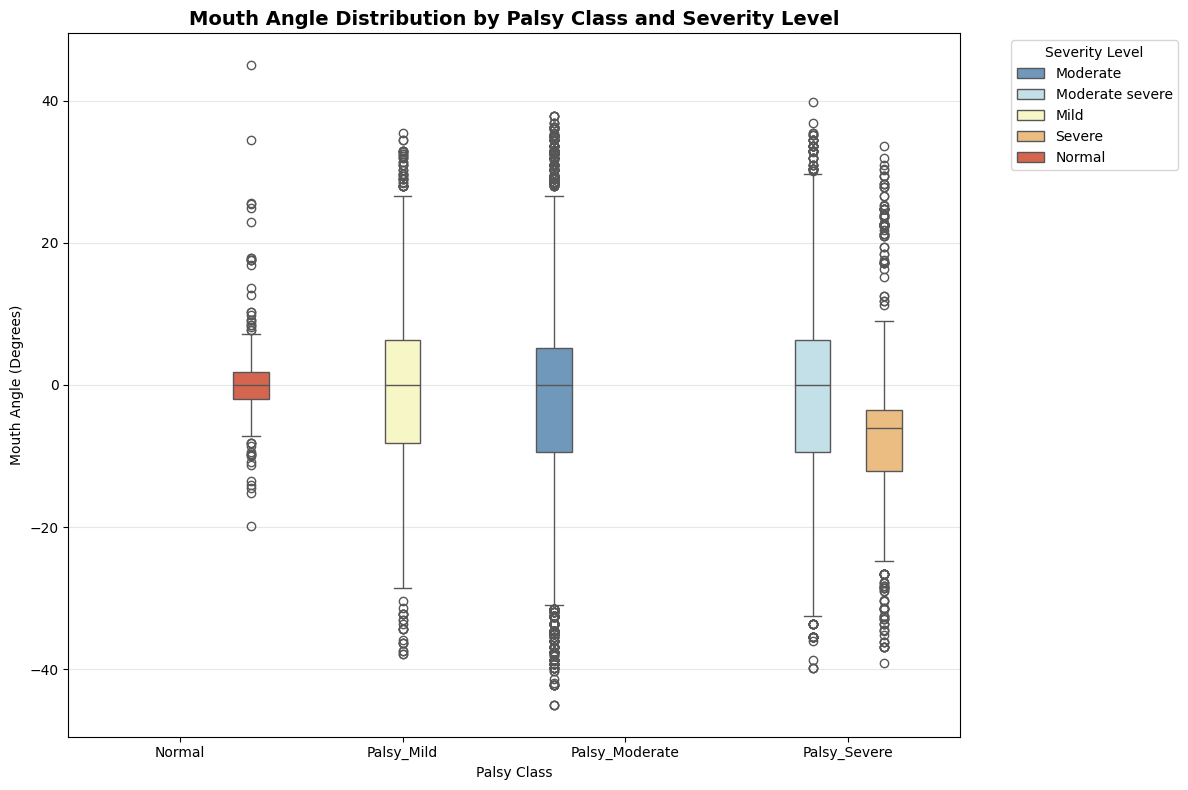

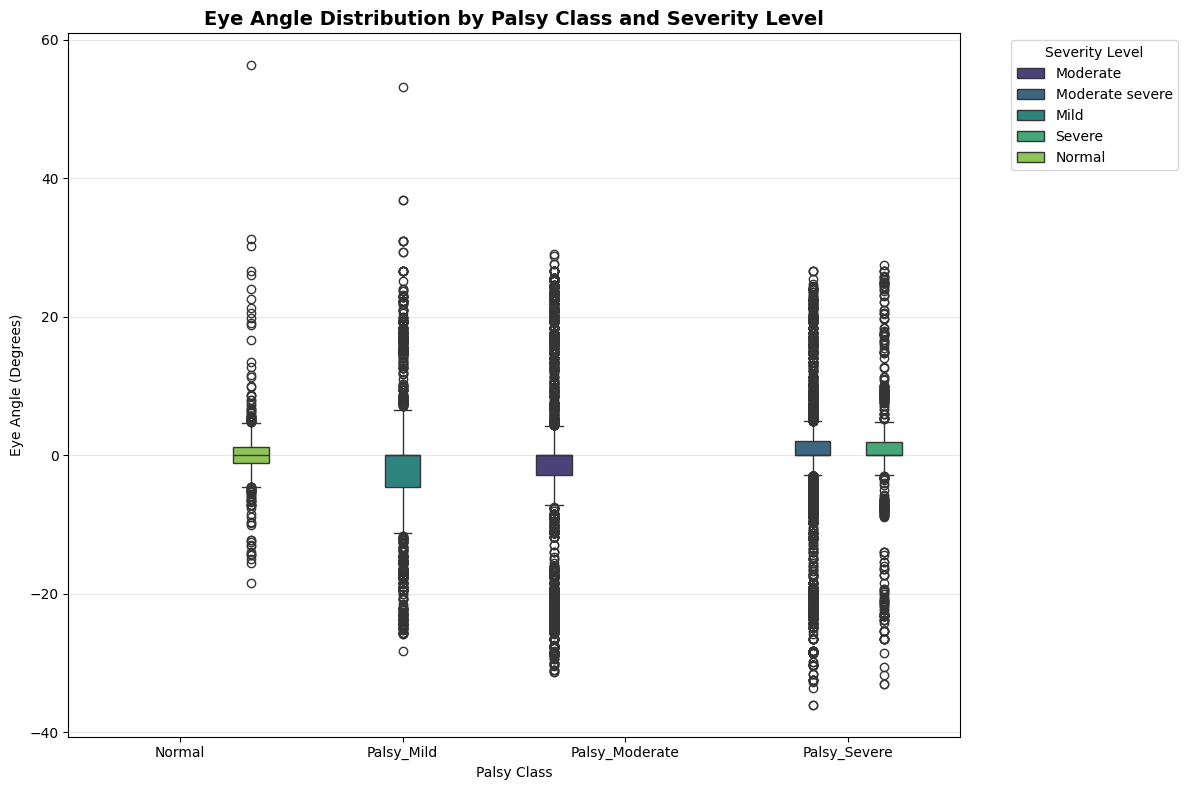

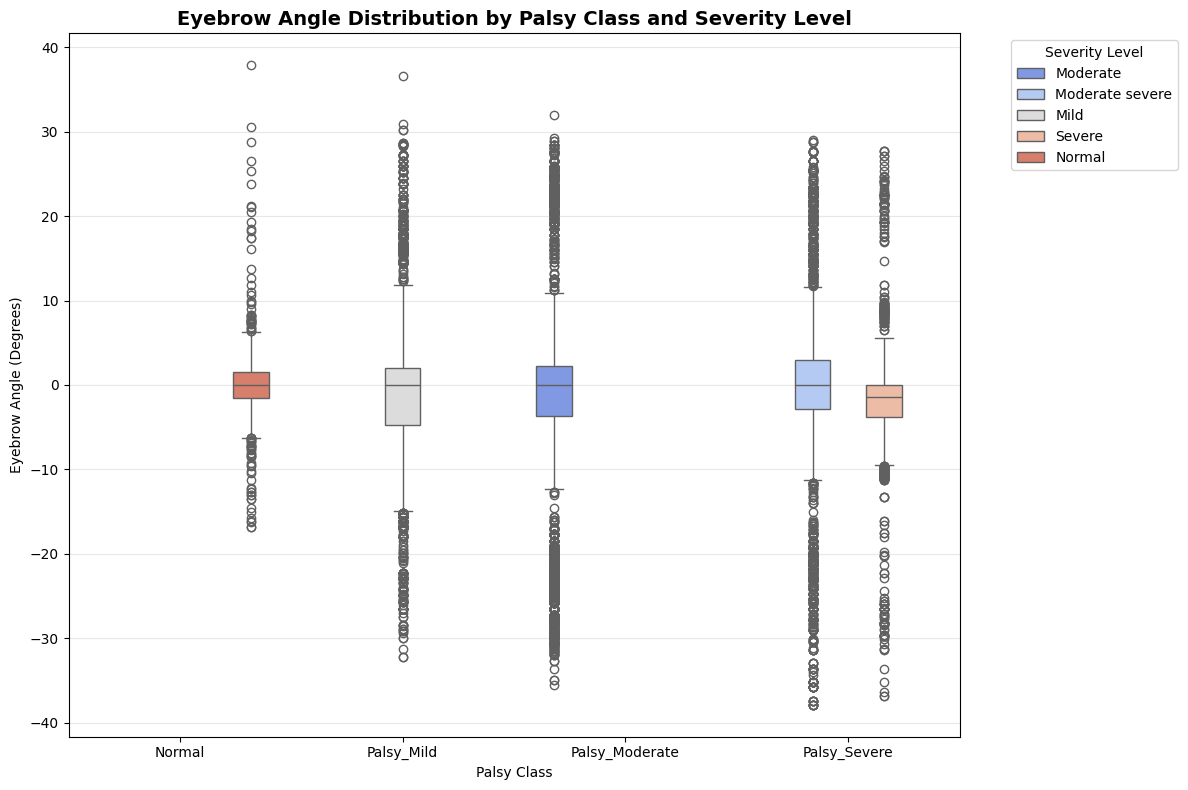

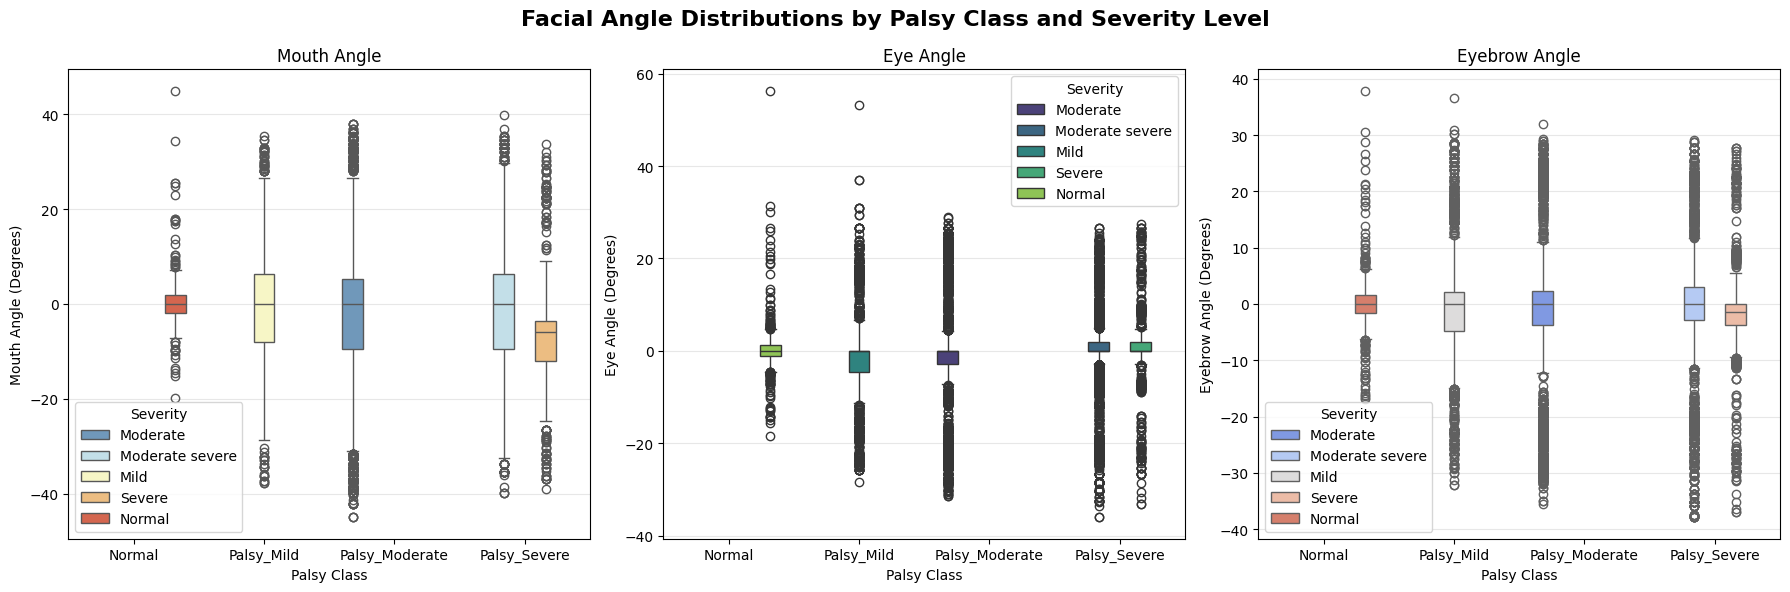

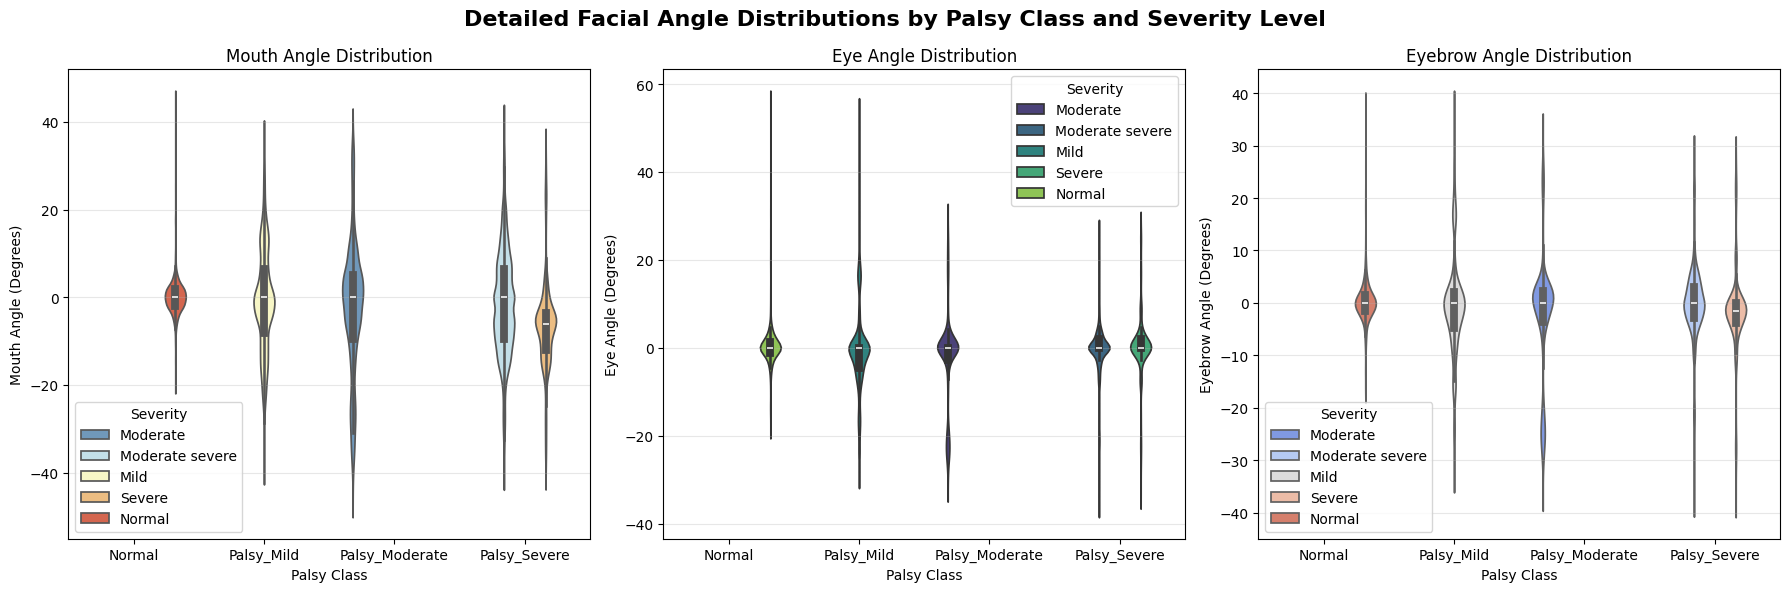

DETAILED STATISTICS BY CLASS AND SEVERITY

MOUTH ANGLE STATISTICS:
--------------------------------------------------
                                count   mean     std     min     max  median
class_name     severity                                                     
Normal         Mild                 0    NaN     NaN     NaN     NaN     NaN
               Moderate             0    NaN     NaN     NaN     NaN     NaN
               Moderate severe      0    NaN     NaN     NaN     NaN     NaN
               Normal             996  0.140   4.208 -19.799  45.000   0.000
               Severe               0    NaN     NaN     NaN     NaN     NaN
Palsy_Mild     Mild              2935 -0.674  11.855 -37.875  35.538   0.000
               Moderate             0    NaN     NaN     NaN     NaN     NaN
               Moderate severe      0    NaN     NaN     NaN     NaN     NaN
               Normal               0    NaN     NaN     NaN     NaN     NaN
               Severe              

/tmp/ipython-input-3903220439.py:136: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-3903220439.py:136: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-3903220439.py:136: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-3903220439.py:145: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=F

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the results CSV
results_df = pd.read_csv('/content/facial_palsy_dataset/facial_angle_analysis_results.csv')

# Filter for successful analyses
successful_df = results_df[results_df['status'] == 'success']

# Define class order for plotting
class_order = ['Normal', 'Palsy_Mild', 'Palsy_Moderate', 'Palsy_Severe']
successful_df['class_name'] = pd.Categorical(successful_df['class_name'], categories=class_order, ordered=True)

# 1. MOUTH ANGLE - Boxplots per class with severity levels
plt.figure(figsize=(12, 8))
sns.boxplot(data=successful_df, x='class_name', y='mouth_angle', hue='severity',
            palette='RdYlBu_r', showfliers=True, dodge=True)
plt.title('Mouth Angle Distribution by Palsy Class and Severity Level',
          fontsize=14, fontweight='bold')
plt.xlabel('Palsy Class')
plt.ylabel('Mouth Angle (Degrees)')
plt.legend(title='Severity Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. EYE ANGLE - Boxplots per class with severity levels
plt.figure(figsize=(12, 8))
sns.boxplot(data=successful_df, x='class_name', y='eye_angle', hue='severity',
            palette='viridis', showfliers=True, dodge=True)
plt.title('Eye Angle Distribution by Palsy Class and Severity Level',
          fontsize=14, fontweight='bold')
plt.xlabel('Palsy Class')
plt.ylabel('Eye Angle (Degrees)')
plt.legend(title='Severity Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. EYEBROW ANGLE - Boxplots per class with severity levels
plt.figure(figsize=(12, 8))
sns.boxplot(data=successful_df, x='class_name', y='eyebrow_angle', hue='severity',
            palette='coolwarm', showfliers=True, dodge=True)
plt.title('Eyebrow Angle Distribution by Palsy Class and Severity Level',
          fontsize=14, fontweight='bold')
plt.xlabel('Palsy Class')
plt.ylabel('Eyebrow Angle (Degrees)')
plt.legend(title='Severity Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. ALL THREE FEATURES IN SUBPLOTS
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Facial Angle Distributions by Palsy Class and Severity Level',
             fontsize=16, fontweight='bold')

# Mouth angle
sns.boxplot(data=successful_df, x='class_name', y='mouth_angle', hue='severity',
            palette='RdYlBu_r', showfliers=True, dodge=True, ax=axes[0])
axes[0].set_title('Mouth Angle')
axes[0].set_xlabel('Palsy Class')
axes[0].set_ylabel('Mouth Angle (Degrees)')
axes[0].legend(title='Severity')
axes[0].grid(axis='y', alpha=0.3)

# Eye angle
sns.boxplot(data=successful_df, x='class_name', y='eye_angle', hue='severity',
            palette='viridis', showfliers=True, dodge=True, ax=axes[1])
axes[1].set_title('Eye Angle')
axes[1].set_xlabel('Palsy Class')
axes[1].set_ylabel('Eye Angle (Degrees)')
axes[1].legend(title='Severity')
axes[1].grid(axis='y', alpha=0.3)

# Eyebrow angle
sns.boxplot(data=successful_df, x='class_name', y='eyebrow_angle', hue='severity',
            palette='coolwarm', showfliers=True, dodge=True, ax=axes[2])
axes[2].set_title('Eyebrow Angle')
axes[2].set_xlabel('Palsy Class')
axes[2].set_ylabel('Eyebrow Angle (Degrees)')
axes[2].legend(title='Severity')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 5. VIOLIN PLOTS for better distribution visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Detailed Facial Angle Distributions by Palsy Class and Severity Level',
             fontsize=16, fontweight='bold')

# Mouth angle violin plot
sns.violinplot(data=successful_df, x='class_name', y='mouth_angle', hue='severity',
               palette='RdYlBu_r', inner='box', dodge=True, ax=axes[0])
axes[0].set_title('Mouth Angle Distribution')
axes[0].set_xlabel('Palsy Class')
axes[0].set_ylabel('Mouth Angle (Degrees)')
axes[0].legend(title='Severity')
axes[0].grid(axis='y', alpha=0.3)

# Eye angle violin plot
sns.violinplot(data=successful_df, x='class_name', y='eye_angle', hue='severity',
               palette='viridis', inner='box', dodge=True, ax=axes[1])
axes[1].set_title('Eye Angle Distribution')
axes[1].set_xlabel('Palsy Class')
axes[1].set_ylabel('Eye Angle (Degrees)')
axes[1].legend(title='Severity')
axes[1].grid(axis='y', alpha=0.3)

# Eyebrow angle violin plot
sns.violinplot(data=successful_df, x='class_name', y='eyebrow_angle', hue='severity',
               palette='coolwarm', inner='box', dodge=True, ax=axes[2])
axes[2].set_title('Eyebrow Angle Distribution')
axes[2].set_xlabel('Palsy Class')
axes[2].set_ylabel('Eyebrow Angle (Degrees)')
axes[2].legend(title='Severity')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("=" * 80)
print("DETAILED STATISTICS BY CLASS AND SEVERITY")
print("=" * 80)

features = ['mouth_angle', 'eye_angle', 'eyebrow_angle']
feature_names = ['Mouth Angle', 'Eye Angle', 'Eyebrow Angle']

for feature, feature_name in zip(features, feature_names):
    print(f"\n{feature_name.upper()} STATISTICS:")
    print("-" * 50)
    stats = successful_df.groupby(['class_name', 'severity'])[feature].agg([
        'count', 'mean', 'std', 'min', 'max', 'median'
    ]).round(3)
    print(stats)
    print("-" * 50)

# Print sample counts summary
print("\nSAMPLE COUNTS SUMMARY:")
print("=" * 40)
count_summary = successful_df.groupby(['class_name', 'severity']).size().unstack(fill_value=0)
print(count_summary)

Dataset Overview:
Total samples: 18335
Classes distribution:
class_name
Palsy_Severe      7793
Palsy_Moderate    6611
Palsy_Mild        2935
Normal             996
Name: count, dtype: int64
Features available: ['image_path', 'image_name', 'category', 'severity', 'class_label', 'class_name', 'eyebrow_angle', 'eye_angle', 'mouth_angle', 'status']

Class mapping: {'Normal': np.int64(0), 'Palsy_Mild': np.int64(1), 'Palsy_Moderate': np.int64(2), 'Palsy_Severe': np.int64(3)}

Training set size before sampling: 14668
Test set size: 3667

Testing: Original
Training set size after Original: 14668
Class distribution after Original:
  Normal: 797
  Palsy_Mild: 2348
  Palsy_Moderate: 5289
  Palsy_Severe: 6234

Random Forest:
  Training Accuracy: 0.9061
  Test Accuracy: 0.7881
  F1 Score: 0.7883
  Cross-validation: 0.7702 (+/- 0.0136)

Gradient Boosting:
  Training Accuracy: 0.6956
  Test Accuracy: 0.6853
  F1 Score: 0.6802
  Cross-validation: 0.6752 (+/- 0.0151)

SVM:
  Training Accuracy: 0.5534
 

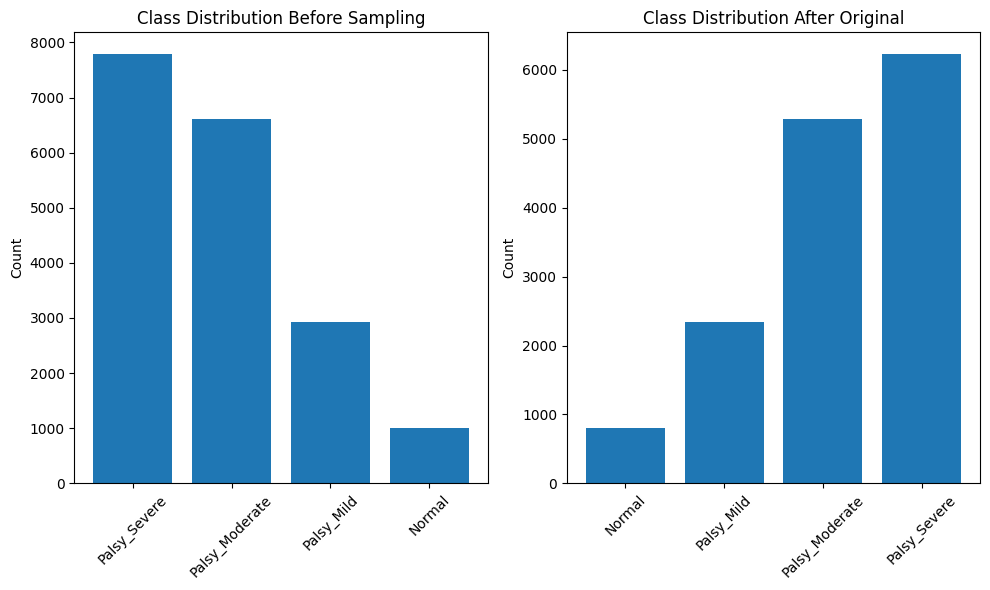


Performing hyperparameter tuning for Random Forest...
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score: 0.7725

FINAL MODEL EVALUATION - Original + Random Forest

Classification Report:
                precision    recall  f1-score   support

        Normal       0.92      0.73      0.81       199
    Palsy_Mild       0.77      0.78      0.78       587
Palsy_Moderate       0.76      0.77      0.77      1322
  Palsy_Severe       0.80      0.81      0.81      1559

      accuracy                           0.79      3667
     macro avg       0.81      0.77      0.79      3667
  weighted avg       0.79      0.79      0.79      3667



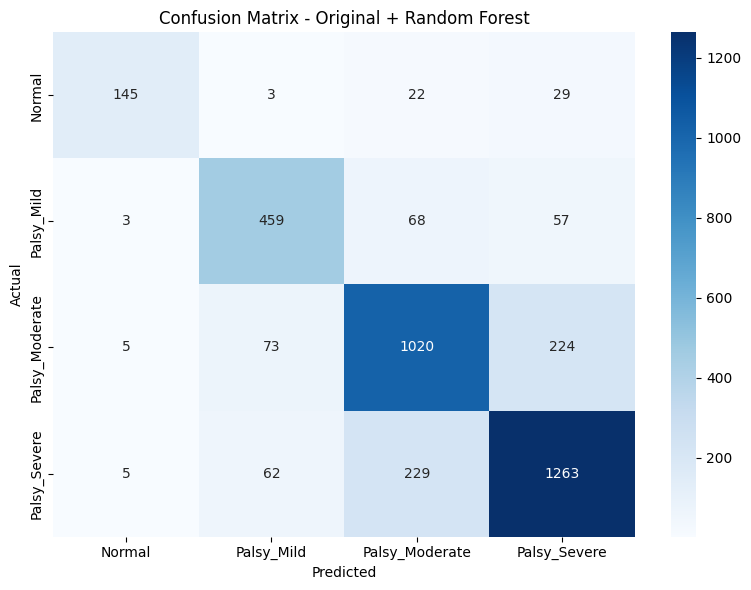

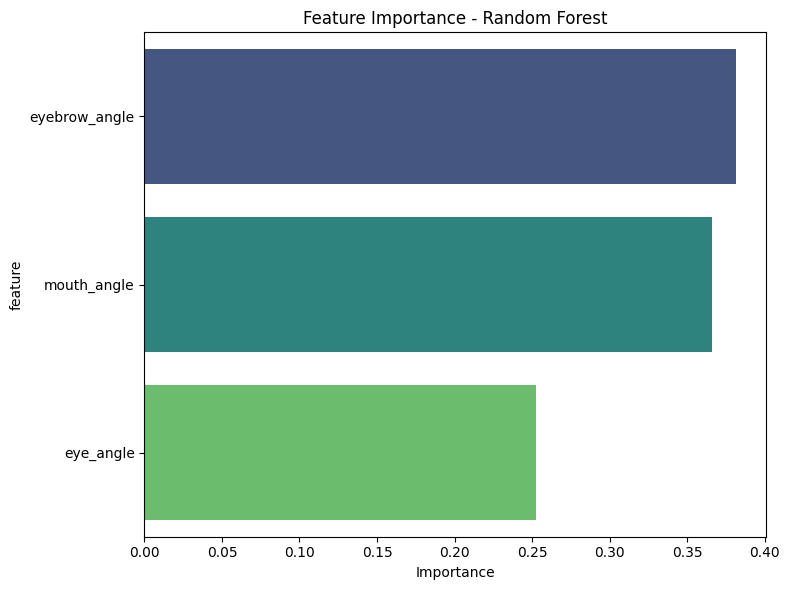


Feature Importance:
         feature  importance
0  eyebrow_angle    0.381626
2    mouth_angle    0.365722
1      eye_angle    0.252652

ALL TECHNIQUES COMPARISON
     Technique              Model  Test_Accuracy  F1_Score  CV_Score
0     Original      Random Forest       0.788110  0.788254  0.770180
20  TomekLinks      Random Forest       0.773657  0.773688  0.785453
25       SMOTE      Random Forest       0.772293  0.773637  0.832893
35  SMOTETomek      Random Forest       0.760295  0.761391  0.845199
4     Original            XGBoost       0.750205  0.749461  0.739910
24  TomekLinks            XGBoost       0.746387  0.745820  0.753641
29       SMOTE            XGBoost       0.725661  0.728116  0.797883
39  SMOTETomek            XGBoost       0.710935  0.713498  0.808082
34    SMOTEENN            XGBoost       0.679847  0.684959  0.966707
1     Original  Gradient Boosting       0.685301  0.680182  0.675211

Best model saved as 'facial_palsy_classifier_balanced.pkl'

EXAMPLE PREDICTI

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/content/facial_palsy_dataset/facial_angle_analysis_results.csv')

# Filter for successful analyses only
df = df[df['status'] == 'success'].copy()

# Display basic info about the dataset
print("Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Classes distribution:\n{df['class_name'].value_counts()}")
print(f"Features available: {df.columns.tolist()}")

# Prepare features and target
features = ['eyebrow_angle', 'eye_angle', 'mouth_angle']
X = df[features]
y = df['class_name']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nClass mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Visualize class distribution before sampling
plt.figure(figsize=(10, 6))
class_counts = df['class_name'].value_counts()
plt.subplot(1, 2, 1)
plt.bar(class_counts.index, class_counts.values)
plt.title('Class Distribution Before Sampling')
plt.xticks(rotation=45)
plt.ylabel('Count')

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set size before sampling: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Apply different sampling techniques and compare
sampling_techniques = {
    'Original': None,
    'RandomUnderSampler': RandomUnderSampler(random_state=42),
    'NearMiss1': NearMiss(version=1),
    'NearMiss2': NearMiss(version=2),
    'TomekLinks': TomekLinks(),
    'SMOTE': SMOTE(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42)
}

# Test different sampling techniques
sampling_results = {}

for technique_name, sampler in sampling_techniques.items():
    print(f"\n{'='*50}")
    print(f"Testing: {technique_name}")
    print(f"{'='*50}")

    if sampler is None:
        # Use original data
        X_train_resampled, y_train_resampled = X_train, y_train
    else:
        # Apply sampling
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

    print(f"Training set size after {technique_name}: {X_train_resampled.shape[0]}")
    print(f"Class distribution after {technique_name}:")
    unique, counts = np.unique(y_train_resampled, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"  {le.inverse_transform([cls])[0]}: {count}")

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'SVM': SVC(random_state=42, probability=True),
        'Logistic Regression': LogisticRegression(random_state=42),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss')
    }

    technique_results = {}
    for name, model in models.items():
        if name in ['SVM', 'Logistic Regression']:
            # Use scaled features for SVM and Logistic Regression
            model.fit(X_train_scaled, y_train_resampled)
            y_pred = model.predict(X_test_scaled)
            train_acc = model.score(X_train_scaled, y_train_resampled)
        else:
            # Use original features for tree-based models
            model.fit(X_train_resampled, y_train_resampled)
            y_pred = model.predict(X_test)
            train_acc = model.score(X_train_resampled, y_train_resampled)

        test_acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

        technique_results[name] = {
            'model': model,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'f1_score': f1,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred
        }

        print(f"\n{name}:")
        print(f"  Training Accuracy: {train_acc:.4f}")
        print(f"  Test Accuracy: {test_acc:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  Cross-validation: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    sampling_results[technique_name] = technique_results

# Find the best sampling technique and model
best_technique = None
best_model_name = None
best_score = 0

for technique_name, results in sampling_results.items():
    for model_name, result in results.items():
        if result['f1_score'] > best_score:
            best_score = result['f1_score']
            best_technique = technique_name
            best_model_name = model_name

print(f"\n{'='*60}")
print(f"BEST COMBINATION: {best_technique} + {best_model_name}")
print(f"Best F1 Score: {best_score:.4f}")
print(f"{'='*60}")

# Prepare the best sampling technique for final training
if best_technique == 'Original':
    sampler_final = None
else:
    sampler_final = sampling_techniques[best_technique]

if sampler_final is None:
    X_train_final, y_train_final = X_train, y_train
else:
    X_train_final, y_train_final = sampler_final.fit_resample(X_train, y_train)

print(f"\nFinal training set size: {X_train_final.shape[0]}")
print("Final class distribution:")
unique, counts = np.unique(y_train_final, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  {le.inverse_transform([cls])[0]}: {count}")

# Visualize class distribution after sampling
plt.subplot(1, 2, 2)
unique, counts = np.unique(y_train_final, return_counts=True)
class_names_final = le.inverse_transform(unique)
plt.bar(class_names_final, counts)
plt.title(f'Class Distribution After {best_technique}')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Scale features for final model
scaler_final = StandardScaler()
X_train_scaled_final = scaler_final.fit_transform(X_train_final)
X_test_scaled_final = scaler_final.transform(X_test)

# Train the best model with hyperparameter tuning
best_result = sampling_results[best_technique][best_model_name]
best_model = best_result['model']

# Hyperparameter tuning
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestClassifier(random_state=42)
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [3, 4, 5]
    }
    base_model = GradientBoostingClassifier(random_state=42)
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.05, 0.01]
    }
    base_model = XGBClassifier(random_state=42, eval_metric='mlogloss')
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
    base_model = SVC(random_state=42, probability=True)
else:  # Logistic Regression
    param_grid = {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear', 'lbfgs']
    }
    base_model = LogisticRegression(random_state=42)

print(f"\nPerforming hyperparameter tuning for {best_model_name}...")
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

if best_model_name in ['SVM', 'Logistic Regression']:
    grid_search.fit(X_train_scaled_final, y_train_final)
    best_model_final = grid_search.best_estimator_
    y_pred_final = best_model_final.predict(X_test_scaled_final)
else:
    grid_search.fit(X_train_final, y_train_final)
    best_model_final = grid_search.best_estimator_
    y_pred_final = best_model_final.predict(X_test)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Final evaluation
print("\n" + "="*60)
print(f"FINAL MODEL EVALUATION - {best_technique} + {best_model_name}")
print("="*60)

# Classification report
class_names = le.classes_
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_technique} + {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature importance for tree-based models
if hasattr(best_model_final, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': best_model_final.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    print("\nFeature Importance:")
    print(feature_importance)

# Compare all sampling techniques
comparison_data = []
for technique_name, results in sampling_results.items():
    for model_name, result in results.items():
        comparison_data.append({
            'Technique': technique_name,
            'Model': model_name,
            'Test_Accuracy': result['test_accuracy'],
            'F1_Score': result['f1_score'],
            'CV_Score': result['cv_mean']
        })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*60)
print("ALL TECHNIQUES COMPARISON")
print("="*60)
print(comparison_df.sort_values('F1_Score', ascending=False).head(10))

# Save the best model
import joblib
model_info = {
    'model': best_model_final,
    'scaler': scaler_final,
    'label_encoder': le,
    'features': features,
    'class_names': class_names,
    'sampling_technique': best_technique,
    'model_name': best_model_name
}

joblib.dump(model_info, 'facial_palsy_classifier_balanced.pkl')
print(f"\nBest model saved as 'facial_palsy_classifier_balanced.pkl'")

# Example prediction on new data
print("\n" + "="*60)
print("EXAMPLE PREDICTION")
print("="*60)
sample_data = X_test.iloc[:5].copy()
if best_model_name in ['SVM', 'Logistic Regression']:
    sample_scaled = scaler_final.transform(sample_data)
    predictions = best_model_final.predict(sample_scaled)
else:
    predictions = best_model_final.predict(sample_data)

predicted_classes = le.inverse_transform(predictions)
true_classes = le.inverse_transform(y_test[:5])
print("Sample predictions:")
for i, (idx, row) in enumerate(sample_data.iterrows()):
    print(f"Sample {i+1}: {dict(row)}")
    print(f"  -> True: {true_classes[i]}, Predicted: {predicted_classes[i]}")
    print()

Dataset Overview:
Total samples: 18335
Classes distribution:
class_name
Palsy_Severe      7793
Palsy_Moderate    6611
Palsy_Mild        2935
Normal             996
Name: count, dtype: int64
Features available: ['image_path', 'image_name', 'category', 'severity', 'class_label', 'class_name', 'eyebrow_angle', 'eye_angle', 'mouth_angle', 'status']

Class mapping: {'Normal': np.int64(0), 'Palsy_Mild': np.int64(1), 'Palsy_Moderate': np.int64(2), 'Palsy_Severe': np.int64(3)}

Training set size before undersampling: 14668
Test set size: 3667

Applying RandomUnderSampler
Training set size after undersampling: 3188
Class distribution after undersampling:
  Normal: 797
  Palsy_Mild: 797
  Palsy_Moderate: 797
  Palsy_Severe: 797


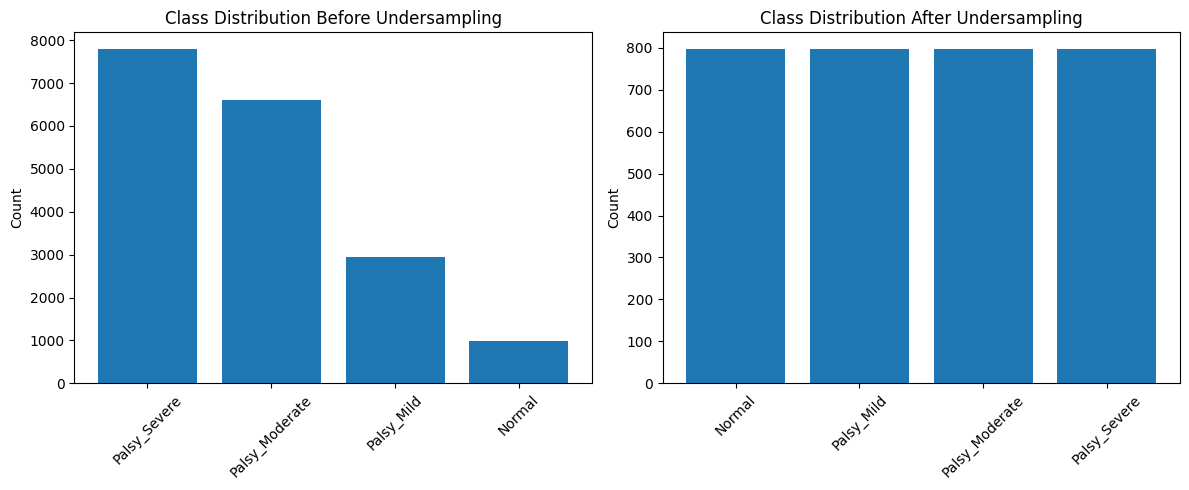


Training: Random Forest

Random Forest Results:
  Training Accuracy: 0.9476
  Test Accuracy: 0.6515
  F1 Score: 0.6551
  Cross-validation: 0.6995 (+/- 0.0216)

Performing hyperparameter tuning for Random Forest...
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation score: 0.7041

FINAL MODEL EVALUATION - Random Forest with Undersampling

Classification Report:
                precision    recall  f1-score   support

        Normal       0.42      0.86      0.56       199
    Palsy_Mild       0.54      0.75      0.63       587
Palsy_Moderate       0.70      0.60      0.65      1322
  Palsy_Severe       0.75      0.63      0.69      1559

      accuracy                           0.65      3667
     macro avg       0.60      0.71      0.63      3667
  weighted avg       0.68      0.65      0.66      3667



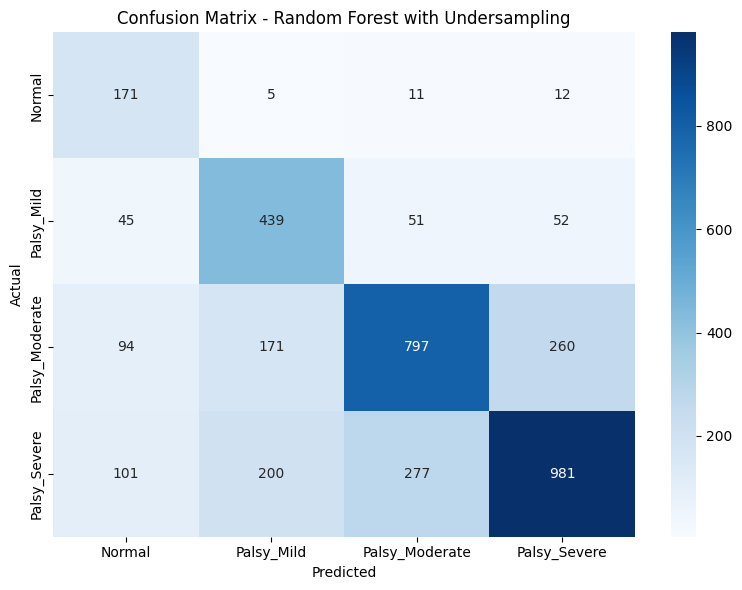

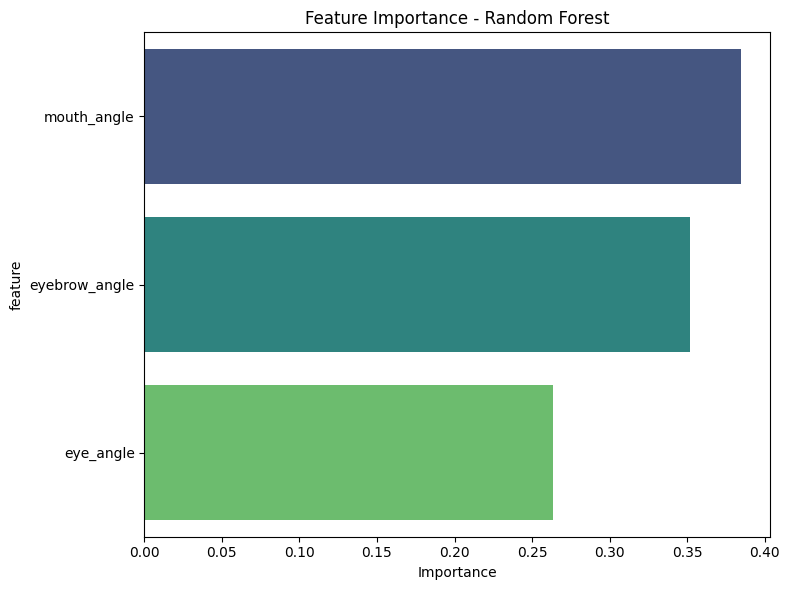


Feature Importance:
         feature  importance
2    mouth_angle    0.384532
0  eyebrow_angle    0.352017
1      eye_angle    0.263451

Model saved as 'facial_palsy_classifier_rf_undersampled.pkl'

EXAMPLE PREDICTION
Sample predictions:
Sample 1: {'eyebrow_angle': np.float64(6.788974574438791), 'eye_angle': np.float64(3.691385986451276), 'mouth_angle': np.float64(6.34019174590991)}
  -> True: Palsy_Severe, Predicted: Palsy_Severe

Sample 2: {'eyebrow_angle': np.float64(-6.519801751656986), 'eye_angle': np.float64(-6.115503566285407), 'mouth_angle': np.float64(0.0)}
  -> True: Palsy_Moderate, Predicted: Palsy_Severe

Sample 3: {'eyebrow_angle': np.float64(-3.468229258917148), 'eye_angle': np.float64(0.0), 'mouth_angle': np.float64(0.0)}
  -> True: Palsy_Moderate, Predicted: Palsy_Mild

Sample 4: {'eyebrow_angle': np.float64(19.02560603756868), 'eye_angle': np.float64(17.650124219930124), 'mouth_angle': np.float64(34.5085229876684)}
  -> True: Palsy_Moderate, Predicted: Palsy_Moderate


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/content/facial_palsy_dataset/facial_angle_analysis_results.csv')

# Filter for successful analyses only and category is 'mouth'
df = df[(df['status'] == 'success') & (df['category'] == 'mouth')].copy()

# Merge 'moderate severe' and 'severe' into 'severe'
df['class_name'] = df['class_name'].replace({'moderate severe': 'severe'})

# Display basic info about the dataset
print("Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Classes distribution:\n{df['class_name'].value_counts()}")
print(f"Features available: {df.columns.tolist()}")

# Prepare features and target
features = ['eyebrow_angle', 'eye_angle', 'mouth_angle']
X = df[features]
y = df['class_name']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nClass mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Visualize class distribution before sampling
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
class_counts_before = df['class_name'].value_counts()
plt.bar(class_counts_before.index, class_counts_before.values)
plt.title('Class Distribution Before Undersampling\n(Mouth Category Only)')
plt.xticks(rotation=45)
plt.ylabel('Count')

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set size before undersampling: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Apply undersampling to balance the classes
print(f"\n{'='*50}")
print(f"Applying RandomUnderSampler")
print(f"{'='*50}")

sampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

print(f"Training set size after undersampling: {X_train_resampled.shape[0]}")
print(f"Class distribution after undersampling:")
unique, counts = np.unique(y_train_resampled, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  {le.inverse_transform([cls])[0]}: {count}")

# Visualize class distribution after sampling
plt.subplot(1, 2, 2)
unique, counts = np.unique(y_train_resampled, return_counts=True)
class_names_final = le.inverse_transform(unique)
plt.bar(class_names_final, counts)
plt.title('Class Distribution After Undersampling\n(Mouth Category Only)')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Train Random Forest model
print(f"\n{'='*50}")
print(f"Training: Random Forest (Mouth Category Only)")
print(f"{'='*50}")

# Initialize and train Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = model.predict(X_test)
train_acc = model.score(X_train_resampled, y_train_resampled)
test_acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

print(f"\nRandom Forest Results:")
print(f"  Training Accuracy: {train_acc:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  F1 Score: {f1:.4f}")
print(f"  Cross-validation: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Hyperparameter tuning for Random Forest
print(f"\nPerforming hyperparameter tuning for Random Forest...")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                          param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Final evaluation
print("\n" + "="*60)
print(f"FINAL MODEL EVALUATION - Random Forest (Mouth Category Only)")
print("="*60)

# Classification report
class_names = le.classes_
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - Random Forest\n(Mouth Category Only)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title(f'Feature Importance - Random Forest\n(Mouth Category Only)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(feature_importance)

# Save the model
import joblib
model_info = {
    'model': best_model,
    'label_encoder': le,
    'features': features,
    'class_names': class_names,
    'sampling_technique': 'RandomUnderSampler',
    'category': 'mouth'
}

joblib.dump(model_info, 'facial_palsy_classifier_rf_mouth_only.pkl')
print(f"\nModel saved as 'facial_palsy_classifier_rf_mouth_only.pkl'")

# Example prediction on new data
print("\n" + "="*60)
print("EXAMPLE PREDICTION")
print("="*60)
sample_data = X_test.iloc[:5].copy()
predictions = best_model.predict(sample_data)
predicted_classes = le.inverse_transform(predictions)
true_classes = le.inverse_transform(y_test[:5])
print("Sample predictions:")
for i, (idx, row) in enumerate(sample_data.iterrows()):
    print(f"Sample {i+1}: {dict(row)}")
    print(f"  -> True: {true_classes[i]}, Predicted: {predicted_classes[i]}")
    print()

# Compare original vs undersampled distribution
print("\n" + "="*60)
print("CLASS DISTRIBUTION COMPARISON (Mouth Category Only)")
print("="*60)
print("Before undersampling:")
original_unique, original_counts = np.unique(y_train, return_counts=True)
for cls, count in zip(original_unique, original_counts):
    print(f"  {le.inverse_transform([cls])[0]}: {count}")

print("\nAfter undersampling:")
resampled_unique, resampled_counts = np.unique(y_train_resampled, return_counts=True)
for cls, count in zip(resampled_unique, resampled_counts):
    print(f"  {le.inverse_transform([cls])[0]}: {count}")

# Display dataset information
print(f"\n{'='*60}")
print("DATASET INFORMATION (Mouth Category Only)")
print(f"{'='*60}")
print(f"Total samples in filtered dataset: {len(df)}")
print(f"Number of features: {len(features)}")
print(f"Features used: {features}")
print(f"Classes: {list(le.classes_)}")

Dataset Overview:
Total samples: 4698
Classes distribution:
class_name
Palsy_Severe      3095
Palsy_Mild         933
Palsy_Moderate     670
Name: count, dtype: int64
Features available: ['image_path', 'image_name', 'category', 'severity', 'class_label', 'class_name', 'eyebrow_angle', 'eye_angle', 'mouth_angle', 'status']

Class mapping: {'Palsy_Mild': np.int64(0), 'Palsy_Moderate': np.int64(1), 'Palsy_Severe': np.int64(2)}

Training set size before undersampling: 3758
Test set size: 940

Applying RandomUnderSampler
Training set size after undersampling: 1608
Class distribution after undersampling:
  Palsy_Mild: 536
  Palsy_Moderate: 536
  Palsy_Severe: 536


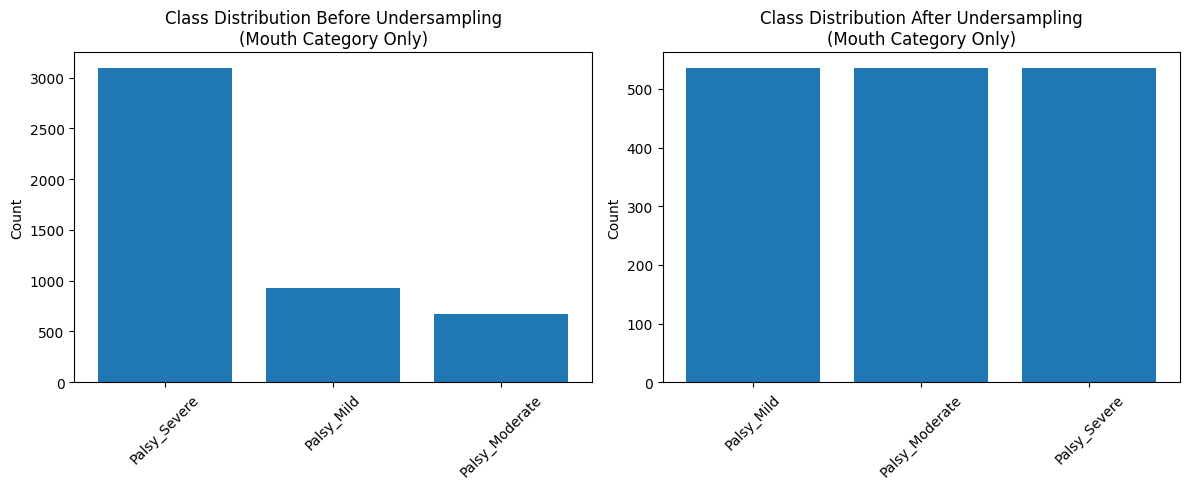


Training: Random Forest (Mouth Category Only)

Random Forest Results:
  Training Accuracy: 0.9490
  Test Accuracy: 0.8447
  F1 Score: 0.8517
  Cross-validation: 0.8327 (+/- 0.0264)

Performing hyperparameter tuning for Random Forest...
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score: 0.8365

FINAL MODEL EVALUATION - Random Forest (Mouth Category Only)

Classification Report:
                precision    recall  f1-score   support

    Palsy_Mild       0.79      0.96      0.87       187
Palsy_Moderate       0.57      0.87      0.69       134
  Palsy_Severe       0.98      0.80      0.88       619

      accuracy                           0.84       940
     macro avg       0.78      0.88      0.81       940
  weighted avg       0.88      0.84      0.85       940



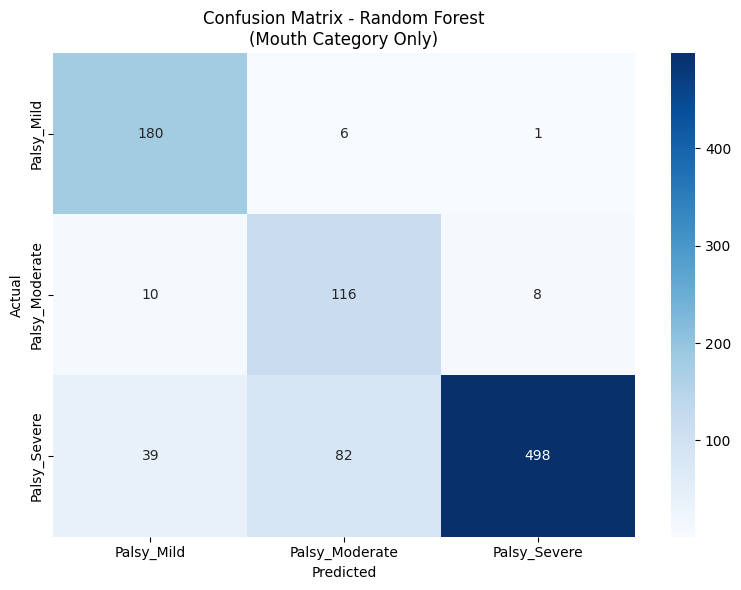

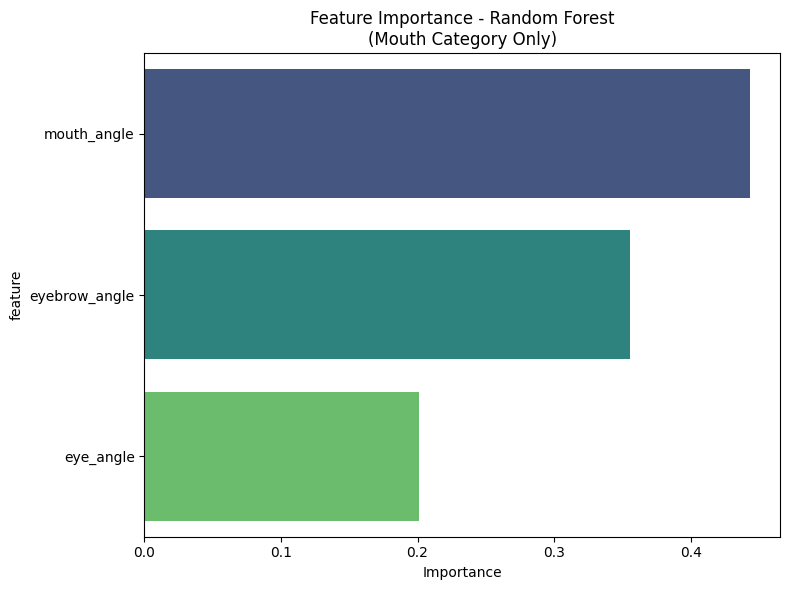


Feature Importance:
         feature  importance
2    mouth_angle    0.443247
0  eyebrow_angle    0.355504
1      eye_angle    0.201249

Model saved as 'facial_palsy_classifier_rf_mouth_only.pkl'

EXAMPLE PREDICTION
Sample predictions:
Sample 1: {'eyebrow_angle': np.float64(-2.6630007660671438), 'eye_angle': np.float64(0.0), 'mouth_angle': np.float64(12.804266065286752)}
  -> True: Palsy_Mild, Predicted: Palsy_Mild

Sample 2: {'eyebrow_angle': np.float64(0.0), 'eye_angle': np.float64(0.0), 'mouth_angle': np.float64(-14.03624346792648)}
  -> True: Palsy_Severe, Predicted: Palsy_Severe

Sample 3: {'eyebrow_angle': np.float64(1.4688007143858246), 'eye_angle': np.float64(0.0), 'mouth_angle': np.float64(13.240519915187203)}
  -> True: Palsy_Severe, Predicted: Palsy_Severe

Sample 4: {'eyebrow_angle': np.float64(1.847610265994596), 'eye_angle': np.float64(0.0), 'mouth_angle': np.float64(-12.0947570770121)}
  -> True: Palsy_Severe, Predicted: Palsy_Severe

Sample 5: {'eyebrow_angle': np.floa

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/content/facial_angle_analysis_results.csv')

# Filter for successful analyses only and category is 'mouth'
df = df[(df['status'] == 'success') & (df['category'] == 'Mouth')].copy()

# Merge 'moderate severe' and 'severe' into 'severe'
df['class_name'] = df['class_name'].replace({'Moderate severe': 'Severe'})

# Display basic info about the dataset
print("Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Classes distribution:\n{df['class_name'].value_counts()}")
print(f"Features available: {df.columns.tolist()}")

# Prepare features and target
features = ['eyebrow_angle', 'eye_angle', 'mouth_angle']
X = df[features]
y = df['class_name']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nClass mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Visualize class distribution before sampling
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
class_counts_before = df['class_name'].value_counts()
plt.bar(class_counts_before.index, class_counts_before.values)
plt.title('Class Distribution Before Undersampling\n(Mouth Category Only)')
plt.xticks(rotation=45)
plt.ylabel('Count')

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set size before undersampling: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Apply undersampling to balance the classes
print(f"\n{'='*50}")
print(f"Applying RandomUnderSampler")
print(f"{'='*50}")

sampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

print(f"Training set size after undersampling: {X_train_resampled.shape[0]}")
print(f"Class distribution after undersampling:")
unique, counts = np.unique(y_train_resampled, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  {le.inverse_transform([cls])[0]}: {count}")

# Visualize class distribution after sampling
plt.subplot(1, 2, 2)
unique, counts = np.unique(y_train_resampled, return_counts=True)
class_names_final = le.inverse_transform(unique)
plt.bar(class_names_final, counts)
plt.title('Class Distribution After Undersampling\n(Mouth Category Only)')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Train Random Forest model
print(f"\n{'='*50}")
print(f"Training: Random Forest (Mouth Category Only)")
print(f"{'='*50}")

# Initialize and train Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = model.predict(X_test)
train_acc = model.score(X_train_resampled, y_train_resampled)
test_acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

print(f"\nRandom Forest Results:")
print(f"  Training Accuracy: {train_acc:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  F1 Score: {f1:.4f}")
print(f"  Cross-validation: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Hyperparameter tuning for Random Forest
print(f"\nPerforming hyperparameter tuning for Random Forest...")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                          param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Final evaluation
print("\n" + "="*60)
print(f"FINAL MODEL EVALUATION - Random Forest (Mouth Category Only)")
print("="*60)

# Classification report
class_names = le.classes_
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - Random Forest\n(Mouth Category Only)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title(f'Feature Importance - Random Forest\n(Mouth Category Only)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(feature_importance)

# Save the model
import joblib
model_info = {
    'model': best_model,
    'label_encoder': le,
    'features': features,
    'class_names': class_names,
    'sampling_technique': 'RandomUnderSampler',
    'category': 'mouth'
}

joblib.dump(model_info, 'facial_palsy_classifier_rf_mouth_only.pkl')
print(f"\nModel saved as 'facial_palsy_classifier_rf_mouth_only.pkl'")

# Example prediction on new data
print("\n" + "="*60)
print("EXAMPLE PREDICTION")
print("="*60)
sample_data = X_test.iloc[:5].copy()
predictions = best_model.predict(sample_data)
predicted_classes = le.inverse_transform(predictions)
true_classes = le.inverse_transform(y_test[:5])
print("Sample predictions:")
for i, (idx, row) in enumerate(sample_data.iterrows()):
    print(f"Sample {i+1}: {dict(row)}")
    print(f"  -> True: {true_classes[i]}, Predicted: {predicted_classes[i]}")
    print()

# Compare original vs undersampled distribution
print("\n" + "="*60)
print("CLASS DISTRIBUTION COMPARISON (Mouth Category Only)")
print("="*60)
print("Before undersampling:")
original_unique, original_counts = np.unique(y_train, return_counts=True)
for cls, count in zip(original_unique, original_counts):
    print(f"  {le.inverse_transform([cls])[0]}: {count}")

print("\nAfter undersampling:")
resampled_unique, resampled_counts = np.unique(y_train_resampled, return_counts=True)
for cls, count in zip(resampled_unique, resampled_counts):
    print(f"  {le.inverse_transform([cls])[0]}: {count}")

# Display dataset information
print(f"\n{'='*60}")
print("DATASET INFORMATION (Mouth Category Only)")
print(f"{'='*60}")
print(f"Total samples in filtered dataset: {len(df)}")
print(f"Number of features: {len(features)}")
print(f"Features used: {features}")
print(f"Classes: {list(le.classes_)}")


STEP 1: MODEL DOWNLOAD & SETUP
✅ Models loaded successfully


STEP 2: DATASET SETUP - UPLOAD MOUTH.ZIP

📥 Downloading CelebA dataset for normal faces...
Using Colab cache for faster access to the 'celeba-dataset' dataset.
✅ CelebA path: /kaggle/input/celeba-dataset

📦 Please upload Mouth.zip file:


Saving Mouth.zip to Mouth (1).zip

✅ Uploaded 1 file(s)
  - Mouth (1).zip (10.93 MB)

📦 Extracting ZIP files...
  ✅ Extracted: Mouth (1).zip

🔍 Scanning for Mouth category images...
  📂 Found Mouth directory: /content/facial_palsy_dataset/temp_extract_1/Mouth
    ✓ Mouth/Moderate severe → Class 3: 2308 images
    ✓ Mouth/Mild → Class 1: 603 images
    ✓ Mouth/Moderate → Class 2: 576 images
    ✓ Mouth/Severe → Class 3: 414 images

📊 Processing CelebA for normal faces...
✅ Using 500 normal faces


Copying normal faces: 100%|██████████| 500/500 [00:00<00:00, 41128.69it/s]



🎯 Final class distribution:
  Class 1 (Palsy_Mild): 603 images
  Class 2 (Palsy_Moderate): 576 images
  Class 3 (Palsy_Severe): 2722 images

STEP 4: PROCESSING ALL IMAGES

🔄 Processing 4401 images...


Extracting features: 100%|██████████| 4401/4401 [04:25<00:00, 16.61it/s]



✅ Successfully processed: 4398 images

Class distribution:
class_name
Palsy_Severe      2722
Palsy_Mild         603
Palsy_Moderate     576
Normal             497
Name: count, dtype: int64

STEP 5: TRAINING RANDOM FOREST MODEL

Remapped class distribution:
class_remapped
Palsy_Severe    3298
Palsy_Mild       603
Normal           497
Name: count, dtype: int64

Training set: 3518 samples
Test set: 880 samples

✅ Training completed!
Test Accuracy: 0.8591
F1 Score: 0.8663

Classification Report:
              precision    recall  f1-score   support

      Normal       0.64      0.84      0.73        99
  Palsy_Mild       0.65      0.89      0.75       121
Palsy_Severe       0.97      0.86      0.91       660

    accuracy                           0.86       880
   macro avg       0.75      0.86      0.80       880
weighted avg       0.89      0.86      0.87       880



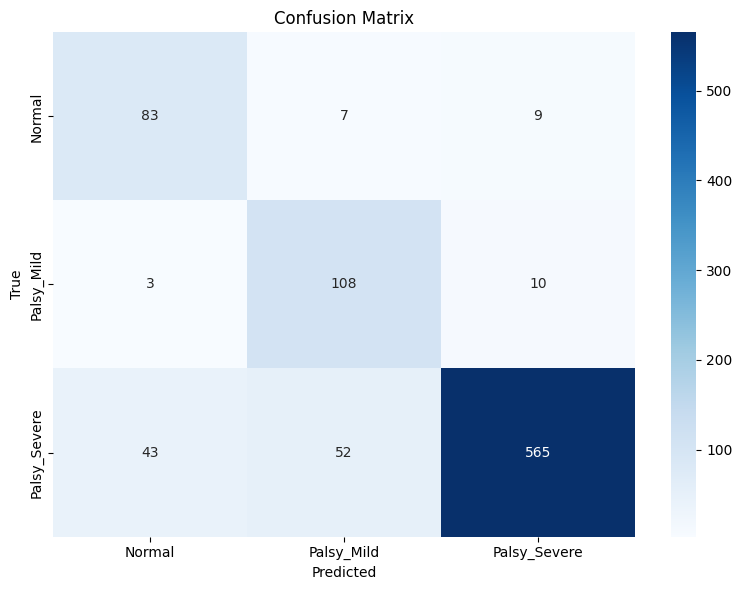


✅ Model saved!

STEP 6: VISUALIZING TEST PREDICTIONS
Error on image 0: extract_angle_features() missing 1 required positional argument: 'landmarks'
Error on image 1: extract_angle_features() missing 1 required positional argument: 'landmarks'
Error on image 2: extract_angle_features() missing 1 required positional argument: 'landmarks'
Error on image 3: extract_angle_features() missing 1 required positional argument: 'landmarks'
Error on image 4: extract_angle_features() missing 1 required positional argument: 'landmarks'
Error on image 5: extract_angle_features() missing 1 required positional argument: 'landmarks'
Error on image 6: extract_angle_features() missing 1 required positional argument: 'landmarks'
Error on image 7: extract_angle_features() missing 1 required positional argument: 'landmarks'
Error on image 8: extract_angle_features() missing 1 required positional argument: 'landmarks'


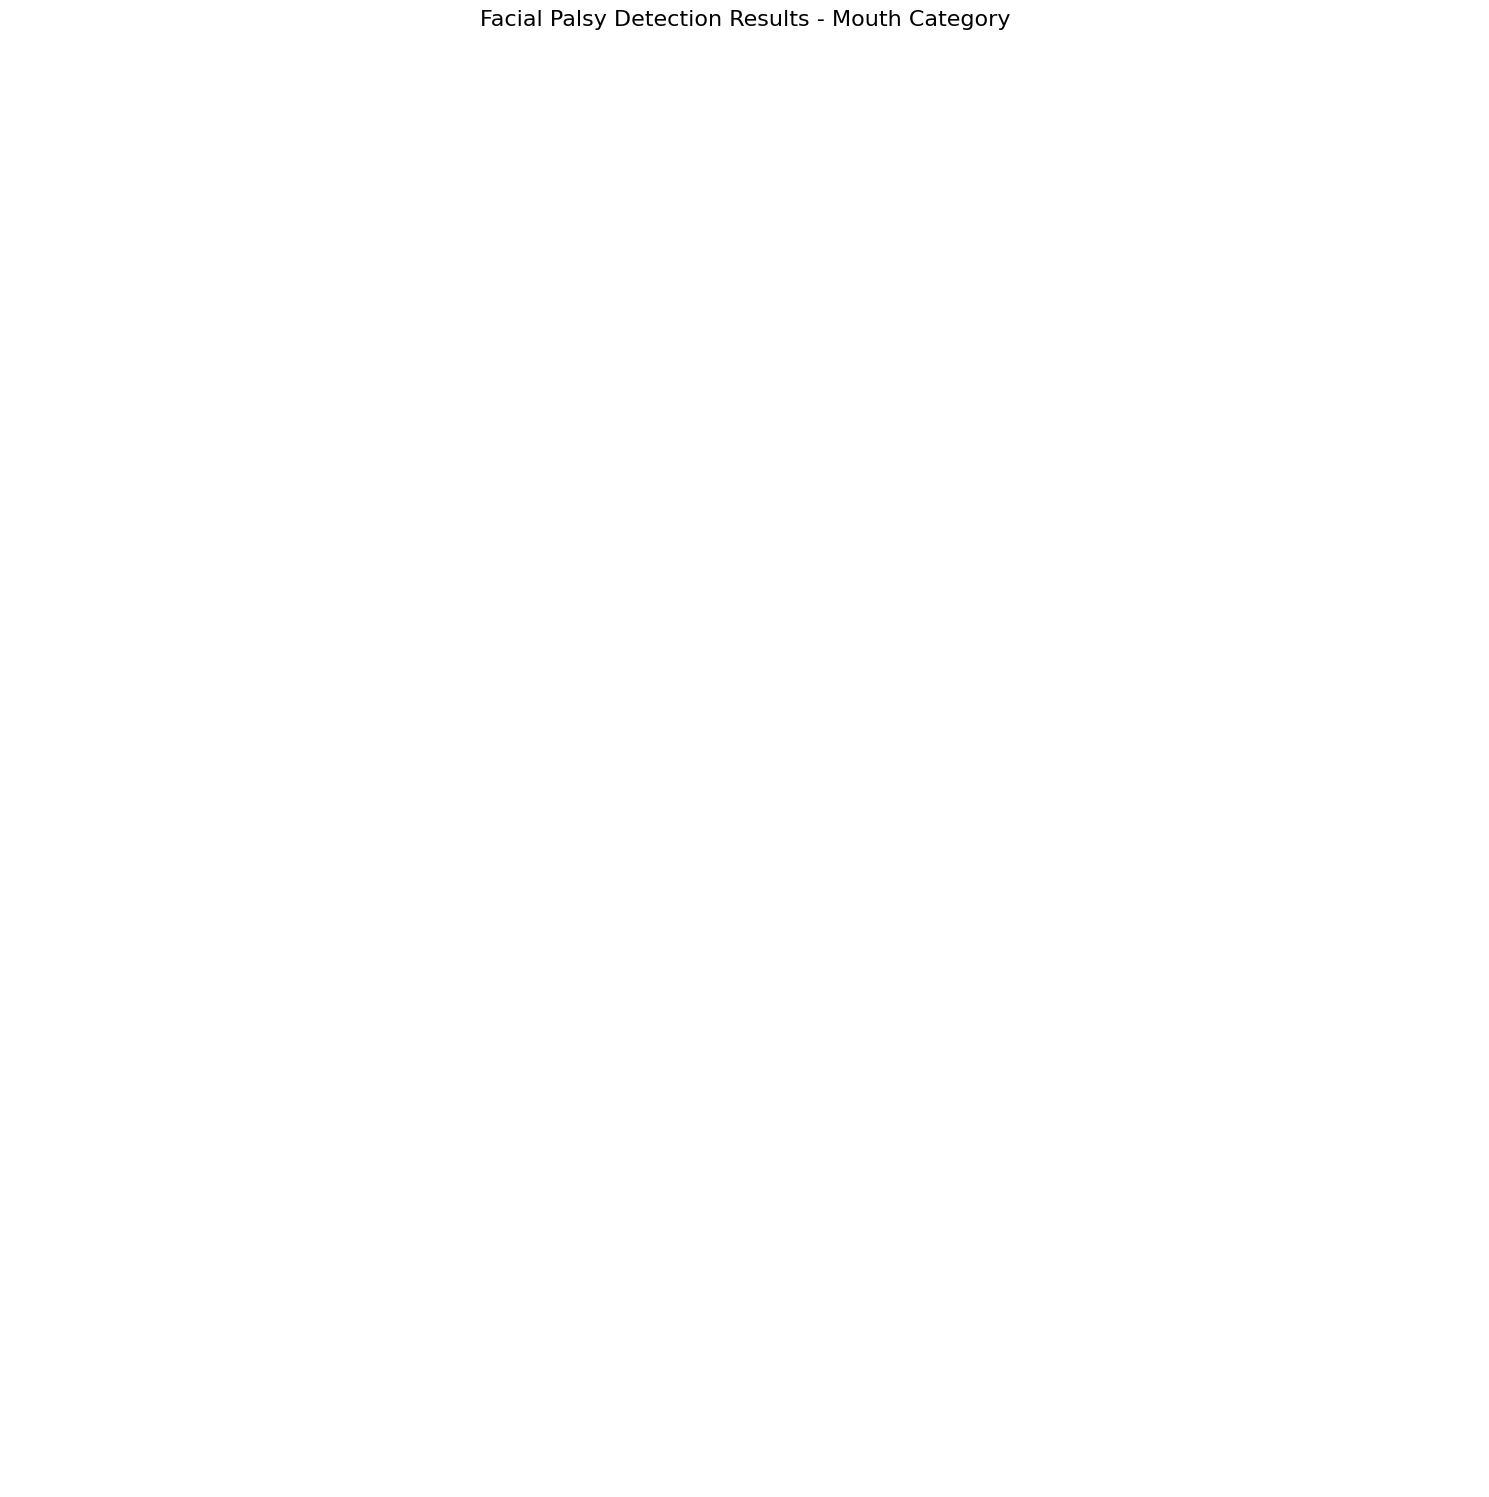


✅ Successfully visualized 0 images

PIPELINE COMPLETE!


In [ ]:
# ============================================================================
# COMPREHENSIVE FACIAL PALSY DETECTION - MOUTH CATEGORY ONLY
# Upload Mouth.zip → Extract Features → Train Model → Visualize Results
# ============================================================================

import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
import os
import urllib.request
import bz2
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
import zipfile
import shutil
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# STEP 1: MODEL DOWNLOAD & SETUP
# ============================================================================

print("\n" + "="*80)
print("STEP 1: MODEL DOWNLOAD & SETUP")
print("="*80)

FACE_PROTO = "deploy.prototxt"
FACE_MODEL = "res10_300x300_ssd_iter_140000.caffemodel"
LANDMARK_MODEL = "shape_predictor_68_face_landmarks.dat"

if not os.path.exists(FACE_PROTO):
    print("📥 Downloading face detection model...")
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt",
        FACE_PROTO
    )

if not os.path.exists(FACE_MODEL):
    print("📥 Downloading face detection weights...")
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel",
        FACE_MODEL
    )

if not os.path.exists(LANDMARK_MODEL):
    print("📥 Downloading facial landmark model...")
    urllib.request.urlretrieve(
        "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2",
        "shape_predictor_68_face_landmarks.dat.bz2"
    )
    print("🔧 Extracting landmark model...")
    with bz2.open("shape_predictor_68_face_landmarks.dat.bz2") as f:
        with open(LANDMARK_MODEL, 'wb') as out:
            out.write(f.read())

face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
landmark_predictor = dlib.shape_predictor(LANDMARK_MODEL)
print("✅ Models loaded successfully\n")

# ============================================================================
# STEP 2: DATASET SETUP - UPLOAD MOUTH.ZIP
# ============================================================================

print("\n" + "="*80)
print("STEP 2: DATASET SETUP - UPLOAD MOUTH.ZIP")
print("="*80)

print("\n📥 Downloading CelebA dataset for normal faces...")
try:
    import kagglehub
    celeba_path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
    print(f"✅ CelebA path: {celeba_path}")
except Exception as e:
    print(f"⚠️  CelebA download failed: {e}")
    celeba_path = "/content/celeba_temp"

DATASET_DIR = Path("/content/facial_palsy_dataset")
NORMAL_DIR = DATASET_DIR / "normal"
NORMAL_DIR.mkdir(parents=True, exist_ok=True)

print("\n📦 Please upload Mouth.zip file:")
from google.colab import files
uploaded_files = files.upload()

print(f"\n✅ Uploaded {len(uploaded_files)} file(s)")
for filename in uploaded_files.keys():
    size_mb = len(uploaded_files[filename]) / (1024 * 1024)
    print(f"  - {filename} ({size_mb:.2f} MB)")

# Extract uploaded ZIP files
print("\n📦 Extracting ZIP files...")
temp_extract_dirs = []

for idx, zip_filename in enumerate(uploaded_files.keys(), 1):
    temp_extract_dir = DATASET_DIR / f"temp_extract_{idx}"
    temp_extract_dir.mkdir(exist_ok=True)
    temp_extract_dirs.append(temp_extract_dir)

    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(temp_extract_dir)
    print(f"  ✅ Extracted: {zip_filename}")

# Class mapping
SEVERITY_TO_CLASS = {
    'Normal': 0,
    'Mild': 1,
    'Moderate': 2,
    'Moderate severe': 3,
    'Severe': 3
}

CLASS_NAMES = ['Normal', 'Palsy_Mild', 'Palsy_Moderate', 'Palsy_Severe']

# Collect images from Mouth category only
collected_images = defaultdict(lambda: defaultdict(list))
image_labels = {}

print("\n🔍 Scanning for Mouth category images...")
for extract_idx, temp_extract_dir in enumerate(temp_extract_dirs, 1):
    for dirpath in temp_extract_dir.rglob("*"):
        if dirpath.is_dir() and dirpath.name.lower() == "mouth":
            print(f"  📂 Found Mouth directory: {dirpath}")

            search_path = dirpath / "Mouth" if (dirpath / "Mouth").exists() else dirpath

            for severity_dir in search_path.iterdir():
                if severity_dir.is_dir():
                    severity_name = severity_dir.name

                    # Clean severity name
                    for suffix in [' mouth', '_mouth']:
                        if suffix in severity_name.lower():
                            severity_name = severity_name.replace(suffix, '').replace(suffix.title(), '').strip()

                    images_in_dir = (list(severity_dir.glob('*.jpg')) +
                                   list(severity_dir.glob('*.JPG')) +
                                   list(severity_dir.glob('*.jpeg')) +
                                   list(severity_dir.glob('*.png')))

                    if images_in_dir:
                        class_label = SEVERITY_TO_CLASS.get(severity_name)
                        if class_label is not None:
                            print(f"    ✓ Mouth/{severity_name} → Class {class_label}: {len(images_in_dir)} images")
                            for img_path in images_in_dir:
                                collected_images['Mouth'][severity_name].append(img_path)
                                image_labels[str(img_path)] = {
                                    'category': 'Mouth',
                                    'severity': severity_name,
                                    'class_label': class_label
                                }
            break

# Add normal faces from CelebA
TARGET_PER_CLASS = 500  # Adjust as needed

print(f"\n📊 Processing CelebA for normal faces...")
celeba_img_dir = Path(celeba_path) / "img_align_celeba" / "img_align_celeba"
if not celeba_img_dir.exists():
    celeba_img_dir = Path(celeba_path) / "img_align_celeba"

if celeba_img_dir.exists():
    all_celeba = list(celeba_img_dir.glob("*.jpg"))
    normal_images = all_celeba[:TARGET_PER_CLASS] if len(all_celeba) >= TARGET_PER_CLASS else all_celeba
    print(f"✅ Using {len(normal_images)} normal faces")

    for idx, img_path in enumerate(tqdm(normal_images, desc="Copying normal faces")):
        target_path = NORMAL_DIR / f"normal_{idx:04d}.jpg"
        if not target_path.exists():
            shutil.copy(str(img_path), str(target_path))
        image_labels[str(target_path)] = {
            'category': 'Normal',
            'severity': 'Normal',
            'class_label': 0
        }
else:
    print("⚠️  CelebA not found, will use smaller dataset")
    normal_images = []

# Organize images by class
palsy_by_class = {1: [], 2: [], 3: []}

for severity in collected_images['Mouth']:
    class_label = SEVERITY_TO_CLASS.get(severity)
    if class_label and class_label > 0:
        palsy_by_class[class_label].extend(collected_images['Mouth'][severity])

final_images_by_class = {0: [NORMAL_DIR / f"normal_{i:04d}.jpg" for i in range(len(normal_images))]}

print("\n🎯 Final class distribution:")
for class_idx in [1, 2, 3]:
    available = palsy_by_class[class_idx]
    selected = list(available)
    final_images_by_class[class_idx] = selected
    print(f"  Class {class_idx} ({CLASS_NAMES[class_idx]}): {len(selected)} images")

# ============================================================================
# STEP 3: FEATURE EXTRACTION FUNCTIONS
# ============================================================================

def detect_face_dnn(image, confidence_threshold=0.5):
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
                                  (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype(int)
            return dlib.rectangle(int(x1), int(y1), int(x2), int(y2))
    raise ValueError("No face detected")

def get_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face = detect_face_dnn(image)
    shape = landmark_predictor(gray, face)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])
    return landmarks, face

def find_midline(landmarks):
    nose_tip = landmarks[30]
    chin = landmarks[8]
    midline_x = (nose_tip[0] + chin[0]) / 2
    return midline_x

def create_clusters(landmarks, midline_x):
    """Create 6 clusters: left/right for eyebrows, eyes, mouth"""
    clusters = {
        'left_eyebrow': [],
        'right_eyebrow': [],
        'left_eye': [],
        'right_eye': [],
        'left_mouth': [],
        'right_mouth': []
    }

    for i, point in enumerate(landmarks):
        x, y = point

        if 17 <= i <= 26:  # Eyebrow points
            if x < midline_x:
                clusters['left_eyebrow'].append(point)
            else:
                clusters['right_eyebrow'].append(point)

        elif 36 <= i <= 47:  # Eye points
            if x < midline_x:
                clusters['left_eye'].append(point)
            else:
                clusters['right_eye'].append(point)

        elif 48 <= i <= 67:  # Mouth points
            if x < midline_x:
                clusters['left_mouth'].append(point)
            else:
                clusters['right_mouth'].append(point)

    for cluster_name in clusters:
        clusters[cluster_name] = np.array(clusters[cluster_name])

    return clusters

def get_line_angle(start_point, end_point):
    """Calculate angle of line in degrees (0° = horizontal)"""
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    angle = np.degrees(np.arctan2(dy, dx))
    return angle

def extract_angle_features(clusters, landmarks):
    """Extract only 3 angle features using clusters"""
    features = {}

    # Eyebrow angle: left outer to right outer
    eyebrow_left = clusters['left_eyebrow'][0] if len(clusters['left_eyebrow']) > 0 else landmarks[17]
    eyebrow_right = clusters['right_eyebrow'][-1] if len(clusters['right_eyebrow']) > 0 else landmarks[26]
    features['eyebrow_angle'] = get_line_angle(eyebrow_left, eyebrow_right)

    # Eye angle: left outer corner to right outer corner
    eye_left = clusters['left_eye'][0] if len(clusters['left_eye']) > 0 else landmarks[36]
    eye_right = clusters['right_eye'][3] if len(clusters['right_eye']) > 0 else landmarks[45]
    features['eye_angle'] = get_line_angle(eye_left, eye_right)

    # Mouth angle: single line from left corner to right corner
    mouth_left_corner = landmarks[48]
    mouth_right_corner = landmarks[54]
    features['mouth_angle'] = get_line_angle(mouth_left_corner, mouth_right_corner)

    return features

# ============================================================================
# STEP 4: PROCESS ALL IMAGES
# ============================================================================

print("\n" + "="*80)
print("STEP 4: PROCESSING ALL IMAGES")
print("="*80)

all_images = []
for class_idx in range(4):
    all_images.extend(final_images_by_class[class_idx])

results = []
print(f"\n🔄 Processing {len(all_images)} images...")

for img_path in tqdm(all_images, desc="Extracting features"):
    try:
        image = cv2.imread(str(img_path))
        if image is None:
            continue

        landmarks, face = get_landmarks(image)
        midline_x = find_midline(landmarks)
        clusters = create_clusters(landmarks, midline_x)
        features = extract_angle_features(clusters, landmarks)

        img_info = image_labels.get(str(img_path), {})

        results.append({
            'image_path': str(img_path),
            'category': img_info.get('category', 'Unknown'),
            'severity': img_info.get('severity', 'Unknown'),
            'class_label': img_info.get('class_label', -1),
            'class_name': CLASS_NAMES[img_info.get('class_label', 0)] if img_info.get('class_label', -1) >= 0 else 'Unknown',
            'eyebrow_angle': features['eyebrow_angle'],
            'eye_angle': features['eye_angle'],
            'mouth_angle': features['mouth_angle'],
            'status': 'success'
        })
    except Exception as e:
        results.append({
            'image_path': str(img_path),
            'category': image_labels.get(str(img_path), {}).get('category', 'Unknown'),
            'severity': image_labels.get(str(img_path), {}).get('severity', 'Unknown'),
            'class_label': image_labels.get(str(img_path), {}).get('class_label', -1),
            'class_name': 'Unknown',
            'eyebrow_angle': np.nan,
            'eye_angle': np.nan,
            'mouth_angle': np.nan,
            'status': f'failed: {str(e)}'
        })

df = pd.DataFrame(results)
df = df[df['status'] == 'success'].copy()

print(f"\n✅ Successfully processed: {len(df)} images")
print(f"\nClass distribution:")
print(df['class_name'].value_counts())

# ============================================================================
# STEP 5: COMBINE CLASSES AND TRAIN MODEL
# ============================================================================

print("\n" + "="*80)
print("STEP 5: TRAINING RANDOM FOREST MODEL")
print("="*80)

# Combine Moderate and Severe into one class
def remap_severity(class_name):
    if class_name == 'Normal':
        return 'Normal'
    elif class_name == 'Palsy_Mild':
        return 'Palsy_Mild'
    elif class_name in ['Palsy_Moderate', 'Palsy_Severe']:
        return 'Palsy_Severe'
    else:
        return class_name

df['class_remapped'] = df['class_name'].apply(remap_severity)

print("\nRemapped class distribution:")
print(df['class_remapped'].value_counts())

# Prepare features
features = ['eyebrow_angle', 'eye_angle', 'mouth_angle']
X = df[features].values
y = df['class_remapped'].values

class_mapping = {'Normal': 0, 'Palsy_Mild': 1, 'Palsy_Severe': 2}
y_numeric = np.array([class_mapping[label] for label in y])
class_names_final = ['Normal', 'Palsy_Mild', 'Palsy_Severe']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_numeric, test_size=0.2, random_state=42, stratify=y_numeric
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n✅ Training completed!")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names_final))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_final, yticklabels=class_names_final)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Save model
joblib.dump({
    'model': rf_model,
    'class_names': class_names_final,
    'features': features
}, 'facial_palsy_rf_model.pkl')
print("\n✅ Model saved!")

# ============================================================================
# STEP 6: VISUALIZE PREDICTIONS ON TEST IMAGES
# ============================================================================

print("\n" + "="*80)
print("STEP 6: VISUALIZING TEST PREDICTIONS")
print("="*80)

# Split dataframe same way
_, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class_remapped'])

# Select equal samples from each class
samples_per_class = 3
selected_samples = []

for class_name in class_names_final:
    class_samples = test_df[test_df['class_remapped'] == class_name]
    if len(class_samples) >= samples_per_class:
        selected = class_samples.sample(n=samples_per_class, random_state=42)
        selected_samples.append(selected)

sample_df = pd.concat(selected_samples, ignore_index=True)

def visualize_analysis(image, landmarks, features, midline_x, prediction, true_label):
    vis_img = image.copy()
    h, w = vis_img.shape[:2]

    # Draw midline
    cv2.line(vis_img, (int(midline_x), 0), (int(midline_x), h), (0, 255, 0), 1)

    # Draw landmarks
    for point in landmarks:
        cv2.circle(vis_img, tuple(point.astype(int)), 2, (200, 200, 200), -1)

    # Draw angle lines
    cv2.line(vis_img, tuple(landmarks[17].astype(int)), tuple(landmarks[26].astype(int)), (255, 0, 0), 2)
    cv2.line(vis_img, tuple(landmarks[36].astype(int)), tuple(landmarks[45].astype(int)), (0, 255, 0), 2)
    cv2.line(vis_img, tuple(landmarks[48].astype(int)), tuple(landmarks[54].astype(int)), (0, 0, 255), 2)

    # Add angle labels
    mid_eyebrow = ((landmarks[17] + landmarks[26]) / 2).astype(int)
    cv2.putText(vis_img, f"Eyebrow: {features['eyebrow_angle']:.1f}deg",
                tuple(mid_eyebrow + [0, -10]), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

    mid_eye = ((landmarks[36] + landmarks[45]) / 2).astype(int)
    cv2.putText(vis_img, f"Eye: {features['eye_angle']:.1f}deg",
                tuple(mid_eye + [0, 15]), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    mid_mouth = ((landmarks[48] + landmarks[54]) / 2).astype(int)
    cv2.putText(vis_img, f"Mouth: {features['mouth_angle']:.1f}deg",
                tuple(mid_mouth + [0, 25]), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)

    # Draw prediction box
    color_map = {'Normal': (0, 255, 0), 'Palsy_Mild': (0, 255, 255), 'Palsy_Severe': (0, 0, 255)}
    box_color = color_map.get(prediction, (255, 255, 255))

    cv2.rectangle(vis_img, (10, 10), (400, 90), (0, 0, 0), -1)
    cv2.rectangle(vis_img, (10, 10), (400, 90), box_color, 3)
    cv2.putText(vis_img, f"True: {true_label}", (20, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(vis_img, f"Pred: {prediction}", (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    match_text = "CORRECT" if prediction == true_label else "INCORRECT"
    match_color = (0, 255, 0) if prediction == true_label else (0, 0, 255)
    cv2.putText(vis_img, match_text, (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, match_color, 1)

    return vis_img

# Visualize
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

processed = 0
for idx, (_, row) in enumerate(sample_df.iterrows()):
    if idx >= 9:
        break

    try:
        img_path = row['image_path']
        true_label = row['class_remapped']

        image = cv2.imread(str(img_path))
        if image is None:
            continue

        landmarks, _ = get_landmarks(image)
        midline_x = find_midline(landmarks)
        features = extract_angle_features(landmarks)

        X_sample = np.array([[features['eyebrow_angle'], features['eye_angle'], features['mouth_angle']]])
        pred_class = rf_model.predict(X_sample)[0]
        pred_label = class_names_final[pred_class]

        vis_img = visualize_analysis(image, landmarks, features, midline_x, pred_label, true_label)
        img_rgb = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)

        axes[idx].imshow(img_rgb)
        axes[idx].axis('off')

        match = "✓" if pred_label == true_label else "✗"
        color = 'green' if pred_label == true_label else 'red'
        axes[idx].set_title(f"{match} True: {true_label} | Pred: {pred_label}",
                           fontsize=9, color=color, weight='bold')
        processed += 1
    except Exception as e:
        print(f"Error on image {idx}: {e}")
        axes[idx].axis('off')

for idx in range(processed, 9):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Facial Palsy Detection Results - Mouth Category', fontsize=16, y=0.995)
plt.show()

print(f"\n✅ Successfully visualized {processed} images")
print("\n" + "="*80)
print("PIPELINE COMPLETE!")
print("="*80)


STEP 1: MODEL DOWNLOAD & SETUP
✅ Models loaded successfully

Enter path to facial image: /content/sev pal 2.jpg

STEP 2: FACIAL PALSY ANALYSIS

Step 1: Finding midline...
  ✓ Midline X-coordinate: 72.0

Step 2: Creating clusters and calculating areas...
  ✓ 6 clusters created

Step 3: Extracting 9 features...
  Debug - Individual areas:
    Left eye: 56, Right eye: 68
    Left eyebrow: 132, Right eyebrow: 104
    Left mouth: 122, Right mouth: 60
  ✓ 9 features extracted

EXTRACTED FEATURES (9 Total)

AREA DIFFERENCE FEATURES (3):
  Eyebrow Area Diff (L-R):     28.0 pixels
  Eye Area Diff (L-R):        -12.0 pixels
  Mouth Area Diff (L-R):       62.0 pixels

ANGLE FEATURES (3):
  Eyebrow Angle:          0.81°
  Eye Angle:              1.10°
  Mouth Angle:           14.93°




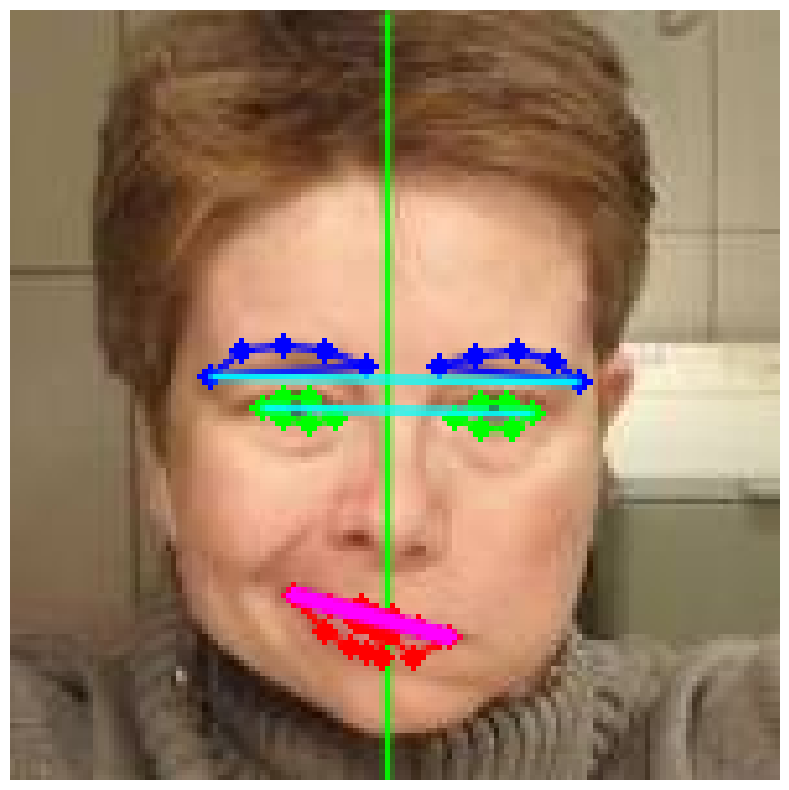

✅ Analysis complete!


In [ ]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
import os
import urllib.request
import bz2

# ============================================================================
# STEP 1: MODEL DOWNLOAD & SETUP
# ============================================================================

print("\n" + "="*80)
print("STEP 1: MODEL DOWNLOAD & SETUP")
print("="*80)

FACE_PROTO = "deploy.prototxt"
FACE_MODEL = "res10_300x300_ssd_iter_140000.caffemodel"

if not os.path.exists(FACE_PROTO):
    print("📥 Downloading face detection model...")
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt",
        FACE_PROTO
    )

if not os.path.exists(FACE_MODEL):
    print("📥 Downloading face detection weights...")
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel",
        FACE_MODEL
    )

LANDMARK_MODEL = "shape_predictor_68_face_landmarks.dat"
if not os.path.exists(LANDMARK_MODEL):
    print("📥 Downloading facial landmark model...")
    urllib.request.urlretrieve(
        "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2",
        "shape_predictor_68_face_landmarks.dat.bz2"
    )
    print("🔧 Extracting landmark model...")
    with bz2.open("shape_predictor_68_face_landmarks.dat.bz2") as f:
        with open(LANDMARK_MODEL, 'wb') as out:
            out.write(f.read())

face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
landmark_predictor = dlib.shape_predictor(LANDMARK_MODEL)
print("✅ Models loaded successfully\n")

# ============================================================================
# FACIAL PALSY DETECTION - 9 FEATURES
# ============================================================================

def detect_face_dnn(image, confidence_threshold=0.5):
    """Detect face using OpenCV DNN"""
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
                                  (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype(int)
            return dlib.rectangle(int(x1), int(y1), int(x2), int(y2))

    raise ValueError("No face detected with sufficient confidence")

def get_landmarks(image):
    """Extract 68 facial landmarks from image"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect face using DNN
    face = detect_face_dnn(image)

    # Get landmarks
    shape = landmark_predictor(gray, face)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])

    return landmarks, face

def find_midline(landmarks):
    """Find vertical midline of face"""
    # Use nose tip and chin for midline
    nose_tip = landmarks[30]
    chin = landmarks[8]
    midline_x = (nose_tip[0] + chin[0]) / 2
    return midline_x

def create_clusters(landmarks, midline_x):
    """
    Create 6 clusters: left/right for eyebrows, eyes, mouth
    Returns dict with cluster points
    """
    clusters = {
        'left_eyebrow': landmarks[17:22],    # Left eyebrow indices
        'right_eyebrow': landmarks[22:27],   # Right eyebrow indices
        'left_eye': landmarks[36:42],        # Left eye indices
        'right_eye': landmarks[42:48],       # Right eye indices
        'left_mouth': [],
        'right_mouth': []
    }

    # Split mouth landmarks by midline
    mouth_points = landmarks[48:68]
    for point in mouth_points:
        if point[0] < midline_x:
            clusters['left_mouth'].append(point)
        else:
            clusters['right_mouth'].append(point)

    # Convert mouth lists to arrays
    clusters['left_mouth'] = np.array(clusters['left_mouth'])
    clusters['right_mouth'] = np.array(clusters['right_mouth'])

    return clusters

def calculate_cluster_area(cluster_points):
    """Calculate area by counting pixels in convex hull"""
    if len(cluster_points) < 3:
        return 0

    try:
        # Create binary mask
        points = cluster_points.astype(np.int32)

        # Get bounding box
        x_min, y_min = points.min(axis=0)
        x_max, y_max = points.max(axis=0)

        # Ensure positive dimensions
        if x_max <= x_min or y_max <= y_min:
            return 0

        # Create mask with proper dimensions
        mask_width = max(x_max - x_min + 10, 1)
        mask_height = max(y_max - y_min + 10, 1)
        mask = np.zeros((mask_height, mask_width), dtype=np.uint8)

        shifted_points = points - [x_min - 5, y_min - 5]

        # Fill convex hull
        hull = cv2.convexHull(shifted_points)
        if len(hull) < 3:
            return 0

        cv2.fillConvexPoly(mask, hull, 1)

        # Count pixels and ensure it's a regular integer
        area = int(np.sum(mask))
        return area

    except Exception as e:
        print(f"Warning: Area calculation failed: {e}")
        return 0

def get_line_angle(start_point, end_point):
    """Calculate angle of line in degrees (0° = horizontal)"""
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    angle = np.degrees(np.arctan2(dy, dx))
    return angle



def extract_9_features(clusters, midline_x, landmarks):
    """
    Extract 9 features:
    - 3 area difference features (eyebrow, eye, mouth)
    - 3 angle features (eyebrow, eye, mouth line angles)
    """
    features = {}

    # Step 1: Calculate areas for 6 clusters with debugging
    left_eyebrow_area = calculate_cluster_area(clusters['left_eyebrow'])
    right_eyebrow_area = calculate_cluster_area(clusters['right_eyebrow'])
    left_eye_area = calculate_cluster_area(clusters['left_eye'])
    right_eye_area = calculate_cluster_area(clusters['right_eye'])
    left_mouth_area = calculate_cluster_area(clusters['left_mouth'])
    right_mouth_area = calculate_cluster_area(clusters['right_mouth'])

    # Debug print to see individual areas
    print(f"  Debug - Individual areas:")
    print(f"    Left eye: {left_eye_area}, Right eye: {right_eye_area}")
    print(f"    Left eyebrow: {left_eyebrow_area}, Right eyebrow: {right_eyebrow_area}")
    print(f"    Left mouth: {left_mouth_area}, Right mouth: {right_mouth_area}")

    # Step 2: Calculate area differences (3 features)
    features['eyebrow_area_diff'] = left_eyebrow_area - right_eyebrow_area
    features['eye_area_diff'] = left_eye_area - right_eye_area
    features['mouth_area_diff'] = left_mouth_area - right_mouth_area

    # Step 3: Calculate angles for 3 feature pairs (3 features)
    # Eyebrow angle: left outer to right outer
    eyebrow_left = clusters['left_eyebrow'][0]
    eyebrow_right = clusters['right_eyebrow'][-1]
    features['eyebrow_angle'] = get_line_angle(eyebrow_left, eyebrow_right)

    # Eye angle: left outer corner to right outer corner
    eye_left = clusters['left_eye'][0]
    eye_right = clusters['right_eye'][3]
    features['eye_angle'] = get_line_angle(eye_left, eye_right)

    # Mouth angle: single line from left corner to right corner
    mouth_left_corner = landmarks[48]  # Left corner of mouth
    mouth_right_corner = landmarks[54]  # Right corner of mouth
    features['mouth_angle'] = get_line_angle(mouth_left_corner, mouth_right_corner)

    return features

def visualize_analysis(image, landmarks, clusters, features, midline_x):
    """
    Visualize the analysis with clusters and lines (NO LEGEND)
    Thinner lines and smaller dots for cleaner visualization
    """
    vis_img = image.copy()
    height, width = vis_img.shape[:2]

    # Draw midline - thinner
    cv2.line(vis_img, (int(midline_x), 0), (int(midline_x), height),
             (0, 255, 0), 1, cv2.LINE_AA)  # Changed from 2 to 1

    # Colors for each feature
    colors = {
        'eyebrow': (255, 0, 0),    # Blue
        'eye': (0, 255, 0),         # Green
        'mouth': (0, 0, 255)        # Red
    }

    # Draw clusters with convex hulls - thinner lines
    for name, points in clusters.items():
        if len(points) < 3:
            continue

        feature_type = name.split('_')[1]  # eyebrow, eye, or mouth
        color = colors[feature_type]

        # Draw convex hull - thinner
        hull = cv2.convexHull(points.astype(np.int32))
        cv2.polylines(vis_img, [hull], True, color, 1, cv2.LINE_AA)  # Changed from 2 to 1

        # Draw landmarks - smaller dots
        for point in points:
            cv2.circle(vis_img, tuple(point.astype(int)), 2, color, -1)  # Changed from 3 to 2

    # Draw lines connecting feature endpoints - thinner
    # Eyebrow line
    eyebrow_left = clusters['left_eyebrow'][0]
    eyebrow_right = clusters['right_eyebrow'][-1]
    cv2.line(vis_img, tuple(eyebrow_left.astype(int)),
             tuple(eyebrow_right.astype(int)), (255, 255, 0), 1, cv2.LINE_AA)  # Changed from 2 to 1

    # Eye line
    eye_left = clusters['left_eye'][0]
    eye_right = clusters['right_eye'][3]
    cv2.line(vis_img, tuple(eye_left.astype(int)),
             tuple(eye_right.astype(int)), (255, 255, 0), 1, cv2.LINE_AA)  # Changed from 2 to 1

    # Mouth line - SINGLE LINE from left corner to right corner
    mouth_left_corner = landmarks[48]
    mouth_right_corner = landmarks[54]

    # Draw single mouth line
    cv2.line(vis_img, tuple(mouth_left_corner.astype(int)),
             tuple(mouth_right_corner.astype(int)), (255, 0, 255), 2, cv2.LINE_AA)  # Magenta

    return vis_img
def analyze_facial_palsy(image_path):
    """
    Main analysis function
    Returns 9 features and visualization
    """
    print(f"\n{'='*80}")
    print(f"STEP 2: FACIAL PALSY ANALYSIS")
    print(f"{'='*80}\n")

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")

    # Step 1: Get landmarks and find midline
    print("Step 1: Finding midline...")
    landmarks, face = get_landmarks(image)
    midline_x = find_midline(landmarks)
    print(f"  ✓ Midline X-coordinate: {midline_x:.1f}")

    # Step 2: Create clusters and calculate areas
    print("\nStep 2: Creating clusters and calculating areas...")
    clusters = create_clusters(landmarks, midline_x)
    print(f"  ✓ 6 clusters created")

    # Step 3: Extract all 9 features
    print("\nStep 3: Extracting 9 features...")
    features = extract_9_features(clusters, midline_x, landmarks)
    print(f"  ✓ 9 features extracted")

    # Print results
    print(f"\n{'='*80}")
    print("EXTRACTED FEATURES (9 Total)")
    print(f"{'='*80}\n")

    print("AREA DIFFERENCE FEATURES (3):")
    print(f"  Eyebrow Area Diff (L-R): {features['eyebrow_area_diff']:>8.1f} pixels")
    print(f"  Eye Area Diff (L-R):     {features['eye_area_diff']:>8.1f} pixels")
    print(f"  Mouth Area Diff (L-R):   {features['mouth_area_diff']:>8.1f} pixels")

    print("\nANGLE FEATURES (3):")
    print(f"  Eyebrow Angle:      {features['eyebrow_angle']:>8.2f}°")
    print(f"  Eye Angle:          {features['eye_angle']:>8.2f}°")
    print(f"  Mouth Angle:        {features['mouth_angle']:>8.2f}°")

    print(f"\n{'='*80}\n")

    # Visualize
    vis_img = visualize_analysis(image, landmarks, clusters, features, midline_x)

    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return features, vis_img

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    image_path = input("Enter path to facial image: ").strip().strip('"').strip("'")

    try:
        features, visualization = analyze_facial_palsy(image_path)
        print("✅ Analysis complete!")
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()


STEP 1: MODEL DOWNLOAD & SETUP
✅ Models loaded successfully

Enter path to facial image: /content/palsy image.jpg

STEP 2: FACIAL PALSY ANALYSIS

Step 1: Finding midline...
  ✓ Midline X-coordinate: 81.0

Step 2: Creating clusters and calculating areas...
  ✓ 6 clusters created

Step 3: Extracting 9 features...
  Debug - Individual areas:
    Left eye: 218, Right eye: 183
    Left eyebrow: 352, Right eyebrow: 332
    Left mouth: 260, Right mouth: 308
  ✓ 9 features extracted

EXTRACTED FEATURES (9 Total)

AREA DIFFERENCE FEATURES (3):
  Eyebrow Area Diff (L-R):     20.0 pixels
  Eye Area Diff (L-R):         35.0 pixels
  Mouth Area Diff (L-R):      -48.0 pixels

ANGLE FEATURES (3):
  Eyebrow Angle:          0.00°
  Eye Angle:              0.66°
  Mouth Angle:           -5.53°




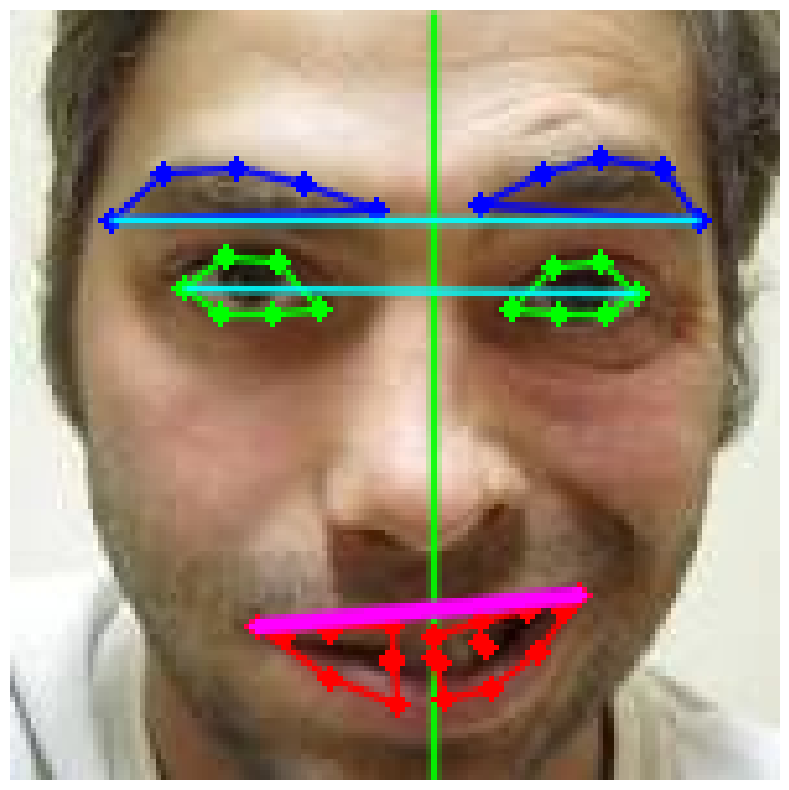

✅ Analysis complete!


In [ ]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
import os
import urllib.request
import bz2

# ============================================================================
# STEP 1: MODEL DOWNLOAD & SETUP
# ============================================================================

print("\n" + "="*80)
print("STEP 1: MODEL DOWNLOAD & SETUP")
print("="*80)

FACE_PROTO = "deploy.prototxt"
FACE_MODEL = "res10_300x300_ssd_iter_140000.caffemodel"

if not os.path.exists(FACE_PROTO):
    print("📥 Downloading face detection model...")
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt",
        FACE_PROTO
    )

if not os.path.exists(FACE_MODEL):
    print("📥 Downloading face detection weights...")
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel",
        FACE_MODEL
    )

LANDMARK_MODEL = "shape_predictor_68_face_landmarks.dat"
if not os.path.exists(LANDMARK_MODEL):
    print("📥 Downloading facial landmark model...")
    urllib.request.urlretrieve(
        "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2",
        "shape_predictor_68_face_landmarks.dat.bz2"
    )
    print("🔧 Extracting landmark model...")
    with bz2.open("shape_predictor_68_face_landmarks.dat.bz2") as f:
        with open(LANDMARK_MODEL, 'wb') as out:
            out.write(f.read())

face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
landmark_predictor = dlib.shape_predictor(LANDMARK_MODEL)
print("✅ Models loaded successfully\n")

# ============================================================================
# FACIAL PALSY DETECTION - 9 FEATURES
# ============================================================================

def detect_face_dnn(image, confidence_threshold=0.5):
    """Detect face using OpenCV DNN"""
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
                                  (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype(int)
            return dlib.rectangle(int(x1), int(y1), int(x2), int(y2))

    raise ValueError("No face detected with sufficient confidence")

def get_landmarks(image):
    """Extract 68 facial landmarks from image"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect face using DNN
    face = detect_face_dnn(image)

    # Get landmarks
    shape = landmark_predictor(gray, face)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])

    return landmarks, face

def find_midline(landmarks):
    """Find vertical midline of face"""
    # Use nose tip and chin for midline
    nose_tip = landmarks[30]
    chin = landmarks[8]
    midline_x = (nose_tip[0] + chin[0]) / 2
    return midline_x

def create_clusters(landmarks, midline_x):
    """
    Create 6 clusters: left/right for eyebrows, eyes, mouth
    Returns dict with cluster points
    """
    clusters = {
        'left_eyebrow': landmarks[17:22],    # Left eyebrow indices
        'right_eyebrow': landmarks[22:27],   # Right eyebrow indices
        'left_eye': landmarks[36:42],        # Left eye indices
        'right_eye': landmarks[42:48],       # Right eye indices
        'left_mouth': [],
        'right_mouth': []
    }

    # Split mouth landmarks by midline
    mouth_points = landmarks[48:68]
    for point in mouth_points:
        if point[0] < midline_x:
            clusters['left_mouth'].append(point)
        else:
            clusters['right_mouth'].append(point)

    # Convert mouth lists to arrays
    clusters['left_mouth'] = np.array(clusters['left_mouth'])
    clusters['right_mouth'] = np.array(clusters['right_mouth'])

    return clusters

def calculate_cluster_area(cluster_points):
    """Calculate area by counting pixels in convex hull"""
    if len(cluster_points) < 3:
        return 0

    try:
        # Create binary mask
        points = cluster_points.astype(np.int32)

        # Get bounding box
        x_min, y_min = points.min(axis=0)
        x_max, y_max = points.max(axis=0)

        # Ensure positive dimensions
        if x_max <= x_min or y_max <= y_min:
            return 0

        # Create mask with proper dimensions
        mask_width = max(x_max - x_min + 10, 1)
        mask_height = max(y_max - y_min + 10, 1)
        mask = np.zeros((mask_height, mask_width), dtype=np.uint8)

        shifted_points = points - [x_min - 5, y_min - 5]

        # Fill convex hull
        hull = cv2.convexHull(shifted_points)
        if len(hull) < 3:
            return 0

        cv2.fillConvexPoly(mask, hull, 1)

        # Count pixels and ensure it's a regular integer
        area = int(np.sum(mask))
        return area

    except Exception as e:
        print(f"Warning: Area calculation failed: {e}")
        return 0

def get_line_angle(start_point, end_point):
    """Calculate angle of line in degrees (0° = horizontal)"""
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    angle = np.degrees(np.arctan2(dy, dx))
    return angle



def extract_9_features(clusters, midline_x, landmarks):
    """
    Extract 9 features:
    - 3 area difference features (eyebrow, eye, mouth)
    - 3 angle features (eyebrow, eye, mouth line angles)
    """
    features = {}

    # Step 1: Calculate areas for 6 clusters with debugging
    left_eyebrow_area = calculate_cluster_area(clusters['left_eyebrow'])
    right_eyebrow_area = calculate_cluster_area(clusters['right_eyebrow'])
    left_eye_area = calculate_cluster_area(clusters['left_eye'])
    right_eye_area = calculate_cluster_area(clusters['right_eye'])
    left_mouth_area = calculate_cluster_area(clusters['left_mouth'])
    right_mouth_area = calculate_cluster_area(clusters['right_mouth'])

    # Debug print to see individual areas
    print(f"  Debug - Individual areas:")
    print(f"    Left eye: {left_eye_area}, Right eye: {right_eye_area}")
    print(f"    Left eyebrow: {left_eyebrow_area}, Right eyebrow: {right_eyebrow_area}")
    print(f"    Left mouth: {left_mouth_area}, Right mouth: {right_mouth_area}")

    # Step 2: Calculate area differences (3 features)
    features['eyebrow_area_diff'] = left_eyebrow_area - right_eyebrow_area
    features['eye_area_diff'] = left_eye_area - right_eye_area
    features['mouth_area_diff'] = left_mouth_area - right_mouth_area

    # Step 3: Calculate angles for 3 feature pairs (3 features)
    # Eyebrow angle: left outer to right outer
    eyebrow_left = clusters['left_eyebrow'][0]
    eyebrow_right = clusters['right_eyebrow'][-1]
    features['eyebrow_angle'] = get_line_angle(eyebrow_left, eyebrow_right)

    # Eye angle: left outer corner to right outer corner
    eye_left = clusters['left_eye'][0]
    eye_right = clusters['right_eye'][3]
    features['eye_angle'] = get_line_angle(eye_left, eye_right)

    # Mouth angle: single line from left corner to right corner
    mouth_left_corner = landmarks[48]  # Left corner of mouth
    mouth_right_corner = landmarks[54]  # Right corner of mouth
    features['mouth_angle'] = get_line_angle(mouth_left_corner, mouth_right_corner)

    return features

def visualize_analysis(image, landmarks, clusters, features, midline_x):
    """
    Visualize the analysis with clusters and lines (NO LEGEND)
    Thinner lines and smaller dots for cleaner visualization
    """
    vis_img = image.copy()
    height, width = vis_img.shape[:2]

    # Draw midline - thinner
    cv2.line(vis_img, (int(midline_x), 0), (int(midline_x), height),
             (0, 255, 0), 1, cv2.LINE_AA)  # Changed from 2 to 1

    # Colors for each feature
    colors = {
        'eyebrow': (255, 0, 0),    # Blue
        'eye': (0, 255, 0),         # Green
        'mouth': (0, 0, 255)        # Red
    }

    # Draw clusters with convex hulls - thinner lines
    for name, points in clusters.items():
        if len(points) < 3:
            continue

        feature_type = name.split('_')[1]  # eyebrow, eye, or mouth
        color = colors[feature_type]

        # Draw convex hull - thinner
        hull = cv2.convexHull(points.astype(np.int32))
        cv2.polylines(vis_img, [hull], True, color, 1, cv2.LINE_AA)  # Changed from 2 to 1

        # Draw landmarks - smaller dots
        for point in points:
            cv2.circle(vis_img, tuple(point.astype(int)), 2, color, -1)  # Changed from 3 to 2

    # Draw lines connecting feature endpoints - thinner
    # Eyebrow line
    eyebrow_left = clusters['left_eyebrow'][0]
    eyebrow_right = clusters['right_eyebrow'][-1]
    cv2.line(vis_img, tuple(eyebrow_left.astype(int)),
             tuple(eyebrow_right.astype(int)), (255, 255, 0), 1, cv2.LINE_AA)  # Changed from 2 to 1

    # Eye line
    eye_left = clusters['left_eye'][0]
    eye_right = clusters['right_eye'][3]
    cv2.line(vis_img, tuple(eye_left.astype(int)),
             tuple(eye_right.astype(int)), (255, 255, 0), 1, cv2.LINE_AA)  # Changed from 2 to 1

    # Mouth line - SINGLE LINE from left corner to right corner
    mouth_left_corner = landmarks[48]
    mouth_right_corner = landmarks[54]

    # Draw single mouth line
    cv2.line(vis_img, tuple(mouth_left_corner.astype(int)),
             tuple(mouth_right_corner.astype(int)), (255, 0, 255), 2, cv2.LINE_AA)  # Magenta

    return vis_img
def analyze_facial_palsy(image_path):
    """
    Main analysis function
    Returns 9 features and visualization
    """
    print(f"\n{'='*80}")
    print(f"STEP 2: FACIAL PALSY ANALYSIS")
    print(f"{'='*80}\n")

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")

    # Step 1: Get landmarks and find midline
    print("Step 1: Finding midline...")
    landmarks, face = get_landmarks(image)
    midline_x = find_midline(landmarks)
    print(f"  ✓ Midline X-coordinate: {midline_x:.1f}")

    # Step 2: Create clusters and calculate areas
    print("\nStep 2: Creating clusters and calculating areas...")
    clusters = create_clusters(landmarks, midline_x)
    print(f"  ✓ 6 clusters created")

    # Step 3: Extract all 9 features
    print("\nStep 3: Extracting 9 features...")
    features = extract_9_features(clusters, midline_x, landmarks)
    print(f"  ✓ 9 features extracted")

    # Print results
    print(f"\n{'='*80}")
    print("EXTRACTED FEATURES (9 Total)")
    print(f"{'='*80}\n")

    print("AREA DIFFERENCE FEATURES (3):")
    print(f"  Eyebrow Area Diff (L-R): {features['eyebrow_area_diff']:>8.1f} pixels")
    print(f"  Eye Area Diff (L-R):     {features['eye_area_diff']:>8.1f} pixels")
    print(f"  Mouth Area Diff (L-R):   {features['mouth_area_diff']:>8.1f} pixels")

    print("\nANGLE FEATURES (3):")
    print(f"  Eyebrow Angle:      {features['eyebrow_angle']:>8.2f}°")
    print(f"  Eye Angle:          {features['eye_angle']:>8.2f}°")
    print(f"  Mouth Angle:        {features['mouth_angle']:>8.2f}°")

    print(f"\n{'='*80}\n")

    # Visualize
    vis_img = visualize_analysis(image, landmarks, clusters, features, midline_x)

    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return features, vis_img

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    image_path = input("Enter path to facial image: ").strip().strip('"').strip("'")

    try:
        features, visualization = analyze_facial_palsy(image_path)
        print("✅ Analysis complete!")
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()


STEP 1: MODEL DOWNLOAD & SETUP
✅ Models loaded successfully

Enter path to facial image: /content/normal.png

STEP 2: FACIAL PALSY ANALYSIS

Step 1: Finding midline...
  ✓ Midline X-coordinate: 167.0

Step 2: Creating clusters and calculating areas...
  ✓ 6 clusters created

Step 3: Extracting 9 features...
  Debug - Individual areas:
    Left eye: 337, Right eye: 334
    Left eyebrow: 520, Right eyebrow: 516
    Left mouth: 346, Right mouth: 500
  ✓ 9 features extracted

EXTRACTED FEATURES (9 Total)

AREA DIFFERENCE FEATURES (3):
  Eyebrow Area Diff (L-R):      4.0 pixels
  Eye Area Diff (L-R):          3.0 pixels
  Mouth Area Diff (L-R):     -154.0 pixels

ANGLE FEATURES (3):
  Eyebrow Angle:         -0.76°
  Eye Angle:             -0.50°
  Mouth Angle:           -1.76°




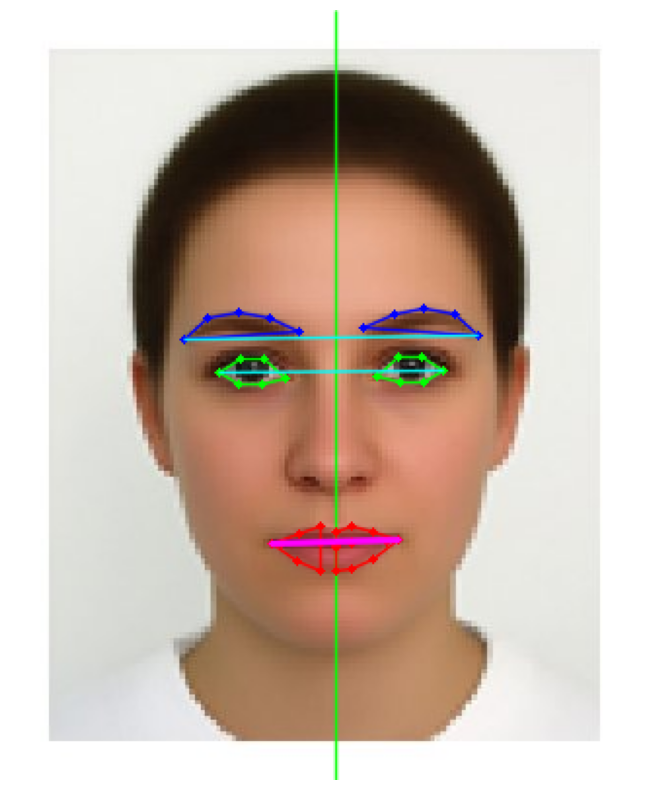

✅ Analysis complete!


In [ ]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
import os
import urllib.request
import bz2

# ============================================================================
# STEP 1: MODEL DOWNLOAD & SETUP
# ============================================================================

print("\n" + "="*80)
print("STEP 1: MODEL DOWNLOAD & SETUP")
print("="*80)

FACE_PROTO = "deploy.prototxt"
FACE_MODEL = "res10_300x300_ssd_iter_140000.caffemodel"

if not os.path.exists(FACE_PROTO):
    print("📥 Downloading face detection model...")
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt",
        FACE_PROTO
    )

if not os.path.exists(FACE_MODEL):
    print("📥 Downloading face detection weights...")
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel",
        FACE_MODEL
    )

LANDMARK_MODEL = "shape_predictor_68_face_landmarks.dat"
if not os.path.exists(LANDMARK_MODEL):
    print("📥 Downloading facial landmark model...")
    urllib.request.urlretrieve(
        "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2",
        "shape_predictor_68_face_landmarks.dat.bz2"
    )
    print("🔧 Extracting landmark model...")
    with bz2.open("shape_predictor_68_face_landmarks.dat.bz2") as f:
        with open(LANDMARK_MODEL, 'wb') as out:
            out.write(f.read())

face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
landmark_predictor = dlib.shape_predictor(LANDMARK_MODEL)
print("✅ Models loaded successfully\n")

# ============================================================================
# FACIAL PALSY DETECTION - 9 FEATURES
# ============================================================================

def detect_face_dnn(image, confidence_threshold=0.5):
    """Detect face using OpenCV DNN"""
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
                                  (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype(int)
            return dlib.rectangle(int(x1), int(y1), int(x2), int(y2))

    raise ValueError("No face detected with sufficient confidence")

def get_landmarks(image):
    """Extract 68 facial landmarks from image"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect face using DNN
    face = detect_face_dnn(image)

    # Get landmarks
    shape = landmark_predictor(gray, face)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])

    return landmarks, face

def find_midline(landmarks):
    """Find vertical midline of face"""
    # Use nose tip and chin for midline
    nose_tip = landmarks[30]
    chin = landmarks[8]
    midline_x = (nose_tip[0] + chin[0]) / 2
    return midline_x

def create_clusters(landmarks, midline_x):
    """
    Create 6 clusters: left/right for eyebrows, eyes, mouth
    Returns dict with cluster points
    """
    clusters = {
        'left_eyebrow': landmarks[17:22],    # Left eyebrow indices
        'right_eyebrow': landmarks[22:27],   # Right eyebrow indices
        'left_eye': landmarks[36:42],        # Left eye indices
        'right_eye': landmarks[42:48],       # Right eye indices
        'left_mouth': [],
        'right_mouth': []
    }

    # Split mouth landmarks by midline
    mouth_points = landmarks[48:68]
    for point in mouth_points:
        if point[0] < midline_x:
            clusters['left_mouth'].append(point)
        else:
            clusters['right_mouth'].append(point)

    # Convert mouth lists to arrays
    clusters['left_mouth'] = np.array(clusters['left_mouth'])
    clusters['right_mouth'] = np.array(clusters['right_mouth'])

    return clusters

def calculate_cluster_area(cluster_points):
    """Calculate area by counting pixels in convex hull"""
    if len(cluster_points) < 3:
        return 0

    try:
        # Create binary mask
        points = cluster_points.astype(np.int32)

        # Get bounding box
        x_min, y_min = points.min(axis=0)
        x_max, y_max = points.max(axis=0)

        # Ensure positive dimensions
        if x_max <= x_min or y_max <= y_min:
            return 0

        # Create mask with proper dimensions
        mask_width = max(x_max - x_min + 10, 1)
        mask_height = max(y_max - y_min + 10, 1)
        mask = np.zeros((mask_height, mask_width), dtype=np.uint8)

        shifted_points = points - [x_min - 5, y_min - 5]

        # Fill convex hull
        hull = cv2.convexHull(shifted_points)
        if len(hull) < 3:
            return 0

        cv2.fillConvexPoly(mask, hull, 1)

        # Count pixels and ensure it's a regular integer
        area = int(np.sum(mask))
        return area

    except Exception as e:
        print(f"Warning: Area calculation failed: {e}")
        return 0

def get_line_angle(start_point, end_point):
    """Calculate angle of line in degrees (0° = horizontal)"""
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    angle = np.degrees(np.arctan2(dy, dx))
    return angle



def extract_9_features(clusters, midline_x, landmarks):
    """
    Extract 9 features:
    - 3 area difference features (eyebrow, eye, mouth)
    - 3 angle features (eyebrow, eye, mouth line angles)
    """
    features = {}

    # Step 1: Calculate areas for 6 clusters with debugging
    left_eyebrow_area = calculate_cluster_area(clusters['left_eyebrow'])
    right_eyebrow_area = calculate_cluster_area(clusters['right_eyebrow'])
    left_eye_area = calculate_cluster_area(clusters['left_eye'])
    right_eye_area = calculate_cluster_area(clusters['right_eye'])
    left_mouth_area = calculate_cluster_area(clusters['left_mouth'])
    right_mouth_area = calculate_cluster_area(clusters['right_mouth'])

    # Debug print to see individual areas
    print(f"  Debug - Individual areas:")
    print(f"    Left eye: {left_eye_area}, Right eye: {right_eye_area}")
    print(f"    Left eyebrow: {left_eyebrow_area}, Right eyebrow: {right_eyebrow_area}")
    print(f"    Left mouth: {left_mouth_area}, Right mouth: {right_mouth_area}")

    # Step 2: Calculate area differences (3 features)
    features['eyebrow_area_diff'] = left_eyebrow_area - right_eyebrow_area
    features['eye_area_diff'] = left_eye_area - right_eye_area
    features['mouth_area_diff'] = left_mouth_area - right_mouth_area

    # Step 3: Calculate angles for 3 feature pairs (3 features)
    # Eyebrow angle: left outer to right outer
    eyebrow_left = clusters['left_eyebrow'][0]
    eyebrow_right = clusters['right_eyebrow'][-1]
    features['eyebrow_angle'] = get_line_angle(eyebrow_left, eyebrow_right)

    # Eye angle: left outer corner to right outer corner
    eye_left = clusters['left_eye'][0]
    eye_right = clusters['right_eye'][3]
    features['eye_angle'] = get_line_angle(eye_left, eye_right)

    # Mouth angle: single line from left corner to right corner
    mouth_left_corner = landmarks[48]  # Left corner of mouth
    mouth_right_corner = landmarks[54]  # Right corner of mouth
    features['mouth_angle'] = get_line_angle(mouth_left_corner, mouth_right_corner)

    return features

def visualize_analysis(image, landmarks, clusters, features, midline_x):
    """
    Visualize the analysis with clusters and lines (NO LEGEND)
    Thinner lines and smaller dots for cleaner visualization
    """
    vis_img = image.copy()
    height, width = vis_img.shape[:2]

    # Draw midline - thinner
    cv2.line(vis_img, (int(midline_x), 0), (int(midline_x), height),
             (0, 255, 0), 1, cv2.LINE_AA)  # Changed from 2 to 1

    # Colors for each feature
    colors = {
        'eyebrow': (255, 0, 0),    # Blue
        'eye': (0, 255, 0),         # Green
        'mouth': (0, 0, 255)        # Red
    }

    # Draw clusters with convex hulls - thinner lines
    for name, points in clusters.items():
        if len(points) < 3:
            continue

        feature_type = name.split('_')[1]  # eyebrow, eye, or mouth
        color = colors[feature_type]

        # Draw convex hull - thinner
        hull = cv2.convexHull(points.astype(np.int32))
        cv2.polylines(vis_img, [hull], True, color, 1, cv2.LINE_AA)  # Changed from 2 to 1

        # Draw landmarks - smaller dots
        for point in points:
            cv2.circle(vis_img, tuple(point.astype(int)), 2, color, -1)  # Changed from 3 to 2

    # Draw lines connecting feature endpoints - thinner
    # Eyebrow line
    eyebrow_left = clusters['left_eyebrow'][0]
    eyebrow_right = clusters['right_eyebrow'][-1]
    cv2.line(vis_img, tuple(eyebrow_left.astype(int)),
             tuple(eyebrow_right.astype(int)), (255, 255, 0), 1, cv2.LINE_AA)  # Changed from 2 to 1

    # Eye line
    eye_left = clusters['left_eye'][0]
    eye_right = clusters['right_eye'][3]
    cv2.line(vis_img, tuple(eye_left.astype(int)),
             tuple(eye_right.astype(int)), (255, 255, 0), 1, cv2.LINE_AA)  # Changed from 2 to 1

    # Mouth line - SINGLE LINE from left corner to right corner
    mouth_left_corner = landmarks[48]
    mouth_right_corner = landmarks[54]

    # Draw single mouth line
    cv2.line(vis_img, tuple(mouth_left_corner.astype(int)),
             tuple(mouth_right_corner.astype(int)), (255, 0, 255), 2, cv2.LINE_AA)  # Magenta

    return vis_img
def analyze_facial_palsy(image_path):
    """
    Main analysis function
    Returns 9 features and visualization
    """
    print(f"\n{'='*80}")
    print(f"STEP 2: FACIAL PALSY ANALYSIS")
    print(f"{'='*80}\n")

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")

    # Step 1: Get landmarks and find midline
    print("Step 1: Finding midline...")
    landmarks, face = get_landmarks(image)
    midline_x = find_midline(landmarks)
    print(f"  ✓ Midline X-coordinate: {midline_x:.1f}")

    # Step 2: Create clusters and calculate areas
    print("\nStep 2: Creating clusters and calculating areas...")
    clusters = create_clusters(landmarks, midline_x)
    print(f"  ✓ 6 clusters created")

    # Step 3: Extract all 9 features
    print("\nStep 3: Extracting 9 features...")
    features = extract_9_features(clusters, midline_x, landmarks)
    print(f"  ✓ 9 features extracted")

    # Print results
    print(f"\n{'='*80}")
    print("EXTRACTED FEATURES (9 Total)")
    print(f"{'='*80}\n")

    print("AREA DIFFERENCE FEATURES (3):")
    print(f"  Eyebrow Area Diff (L-R): {features['eyebrow_area_diff']:>8.1f} pixels")
    print(f"  Eye Area Diff (L-R):     {features['eye_area_diff']:>8.1f} pixels")
    print(f"  Mouth Area Diff (L-R):   {features['mouth_area_diff']:>8.1f} pixels")

    print("\nANGLE FEATURES (3):")
    print(f"  Eyebrow Angle:      {features['eyebrow_angle']:>8.2f}°")
    print(f"  Eye Angle:          {features['eye_angle']:>8.2f}°")
    print(f"  Mouth Angle:        {features['mouth_angle']:>8.2f}°")

    print(f"\n{'='*80}\n")

    # Visualize
    vis_img = visualize_analysis(image, landmarks, clusters, features, midline_x)

    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return features, vis_img

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    image_path = input("Enter path to facial image: ").strip().strip('"').strip("'")

    try:
        features, visualization = analyze_facial_palsy(image_path)
        print("✅ Analysis complete!")
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()


STEP 1: MODEL DOWNLOAD & SETUP
✅ Models loaded successfully

Enter path to facial image: /content/sev pal 2.jpg

STEP 2: FACIAL PALSY ANALYSIS

Step 1: Finding midline...
  ✓ Midline X-coordinate: 72.0

Step 2: Analyzing landmark assignment...

LANDMARK ASSIGNMENT ANALYSIS
Midline X-coordinate: 72.0
--------------------------------------------------------------------------------
Index  X        Y        Side     Feature      Assignment          
--------------------------------------------------------------------------------
0      29.0     71.0     left     jawline      left_jawline        
1      29.0     83.0     left     jawline      left_jawline        
2      30.0     95.0     left     jawline      left_jawline        
3      32.0     107.0    left     jawline      left_jawline        
4      36.0     117.0    left     jawline      left_jawline        
5      43.0     125.0    left     jawline      left_jawline        
6      53.0     131.0    left     jawline      left_jawline 

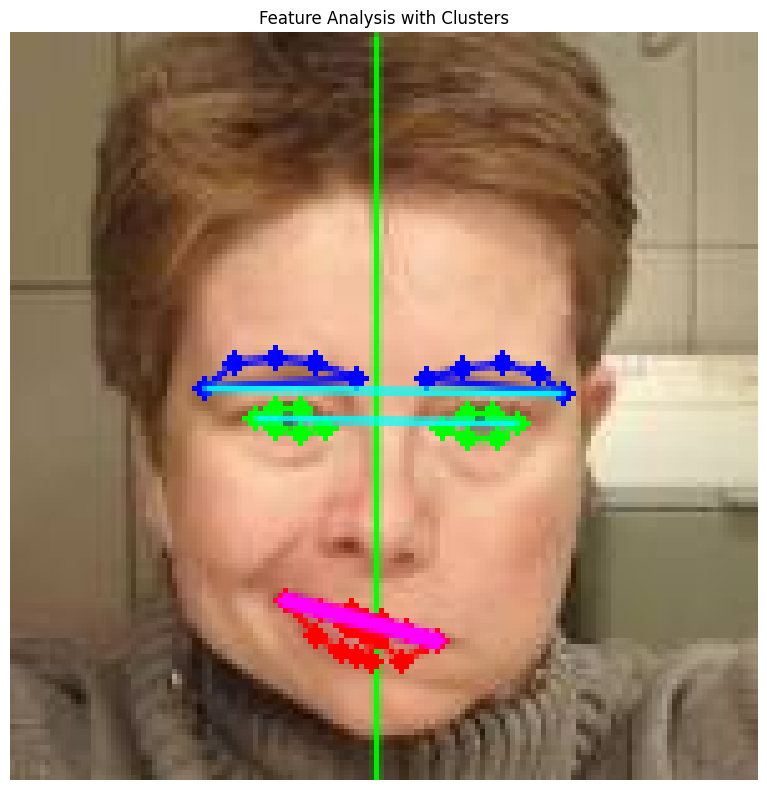

✅ Analysis complete!

FINAL SUMMARY

INTERPRETATION:
  • Significant mouth asymmetry (LEFT side larger)
  • Mouth angle deviation detected (14.93°)


In [ ]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
import os
import urllib.request
import bz2

# ============================================================================
# STEP 1: MODEL DOWNLOAD & SETUP
# ============================================================================

print("\n" + "="*80)
print("STEP 1: MODEL DOWNLOAD & SETUP")
print("="*80)

FACE_PROTO = "deploy.prototxt"
FACE_MODEL = "res10_300x300_ssd_iter_140000.caffemodel"

if not os.path.exists(FACE_PROTO):
    print("📥 Downloading face detection model...")
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt",
        FACE_PROTO
    )

if not os.path.exists(FACE_MODEL):
    print("📥 Downloading face detection weights...")
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel",
        FACE_MODEL
    )

LANDMARK_MODEL = "shape_predictor_68_face_landmarks.dat"
if not os.path.exists(LANDMARK_MODEL):
    print("📥 Downloading facial landmark model...")
    urllib.request.urlretrieve(
        "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2",
        "shape_predictor_68_face_landmarks.dat.bz2"
    )
    print("🔧 Extracting landmark model...")
    with bz2.open("shape_predictor_68_face_landmarks.dat.bz2") as f:
        with open(LANDMARK_MODEL, 'wb') as out:
            out.write(f.read())

face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
landmark_predictor = dlib.shape_predictor(LANDMARK_MODEL)
print("✅ Models loaded successfully\n")

# ============================================================================
# FACIAL PALSY DETECTION - 9 FEATURES
# ============================================================================

def detect_face_dnn(image, confidence_threshold=0.5):
    """Detect face using OpenCV DNN"""
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
                                  (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype(int)
            return dlib.rectangle(int(x1), int(y1), int(x2), int(y2))

    raise ValueError("No face detected with sufficient confidence")

def get_landmarks(image):
    """Extract 68 facial landmarks from image"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect face using DNN
    face = detect_face_dnn(image)

    # Get landmarks
    shape = landmark_predictor(gray, face)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])

    return landmarks, face

def find_midline(landmarks):
    """Find vertical midline of face"""
    # Use nose tip and chin for midline
    nose_tip = landmarks[30]
    chin = landmarks[8]
    midline_x = (nose_tip[0] + chin[0]) / 2
    return midline_x

def get_landmark_feature_type(landmark_index):
    """
    Determine which feature a landmark belongs to based on its index
    """
    if 17 <= landmark_index <= 26:
        return 'eyebrow'
    elif 36 <= landmark_index <= 47:
        return 'eye'
    elif 48 <= landmark_index <= 67:
        return 'mouth'
    elif 27 <= landmark_index <= 35:
        return 'nose'
    elif 0 <= landmark_index <= 16:
        return 'jawline'
    else:
        return 'other'

def create_clusters(landmarks, midline_x):
    """
    Create 6 clusters: left/right for eyebrows, eyes, mouth
    Uses both landmark position (for left/right) and landmark index (for feature type)
    """
    clusters = {
        'left_eyebrow': [],
        'right_eyebrow': [],
        'left_eye': [],
        'right_eye': [],
        'left_mouth': [],
        'right_mouth': []
    }

    # Assign each landmark to the appropriate cluster
    for i, point in enumerate(landmarks):
        x, y = point

        # Determine feature type based on landmark index
        if 17 <= i <= 26:  # Eyebrow points (17-26)
            if x < midline_x:  # Left of midline
                clusters['left_eyebrow'].append(point)
            else:  # Right of midline
                clusters['right_eyebrow'].append(point)

        elif 36 <= i <= 47:  # Eye points (36-47)
            if x < midline_x:  # Left of midline
                clusters['left_eye'].append(point)
            else:  # Right of midline
                clusters['right_eye'].append(point)

        elif 48 <= i <= 67:  # Mouth points (48-67)
            if x < midline_x:  # Left of midline
                clusters['left_mouth'].append(point)
            else:  # Right of midline
                clusters['right_mouth'].append(point)

    # Convert all lists to numpy arrays
    for cluster_name in clusters:
        clusters[cluster_name] = np.array(clusters[cluster_name])

    return clusters

def calculate_cluster_area(cluster_points):
    """Calculate area by counting pixels in convex hull"""
    if len(cluster_points) < 3:
        return 0

    try:
        # Create binary mask
        points = cluster_points.astype(np.int32)

        # Get bounding box
        x_min, y_min = points.min(axis=0)
        x_max, y_max = points.max(axis=0)

        # Ensure positive dimensions
        if x_max <= x_min or y_max <= y_min:
            return 0

        # Create mask with proper dimensions
        mask_width = max(x_max - x_min + 10, 1)
        mask_height = max(y_max - y_min + 10, 1)
        mask = np.zeros((mask_height, mask_width), dtype=np.uint8)

        shifted_points = points - [x_min - 5, y_min - 5]

        # Fill convex hull
        hull = cv2.convexHull(shifted_points)
        if len(hull) < 3:
            return 0

        cv2.fillConvexPoly(mask, hull, 1)

        # Count pixels and ensure it's a regular integer
        area = int(np.sum(mask))
        return area

    except Exception as e:
        print(f"Warning: Area calculation failed: {e}")
        return 0

def get_line_angle(start_point, end_point):
    """Calculate angle of line in degrees (0° = horizontal)"""
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    angle = np.degrees(np.arctan2(dy, dx))
    return angle

def extract_9_features(clusters, midline_x, landmarks):
    """
    Extract 9 features:
    - 3 area difference features (eyebrow, eye, mouth)
    - 3 angle features (eyebrow, eye, mouth line angles)
    """
    features = {}

    # Step 1: Calculate areas for 6 clusters with debugging
    left_eyebrow_area = calculate_cluster_area(clusters['left_eyebrow'])
    right_eyebrow_area = calculate_cluster_area(clusters['right_eyebrow'])
    left_eye_area = calculate_cluster_area(clusters['left_eye'])
    right_eye_area = calculate_cluster_area(clusters['right_eye'])
    left_mouth_area = calculate_cluster_area(clusters['left_mouth'])
    right_mouth_area = calculate_cluster_area(clusters['right_mouth'])

    # Debug print to see individual areas
    print(f"  Debug - Individual areas:")
    print(f"    Left eye: {left_eye_area}, Right eye: {right_eye_area}")
    print(f"    Left eyebrow: {left_eyebrow_area}, Right eyebrow: {right_eyebrow_area}")
    print(f"    Left mouth: {left_mouth_area}, Right mouth: {right_mouth_area}")

    # Step 2: Calculate area differences (3 features)
    features['eyebrow_area_diff'] = left_eyebrow_area - right_eyebrow_area
    features['eye_area_diff'] = left_eye_area - right_eye_area
    features['mouth_area_diff'] = left_mouth_area - right_mouth_area

    # Step 3: Calculate angles for 3 feature pairs (3 features)
    # Eyebrow angle: left outer to right outer
    eyebrow_left = clusters['left_eyebrow'][0] if len(clusters['left_eyebrow']) > 0 else landmarks[17]
    eyebrow_right = clusters['right_eyebrow'][-1] if len(clusters['right_eyebrow']) > 0 else landmarks[26]
    features['eyebrow_angle'] = get_line_angle(eyebrow_left, eyebrow_right)

    # Eye angle: left outer corner to right outer corner
    eye_left = clusters['left_eye'][0] if len(clusters['left_eye']) > 0 else landmarks[36]
    eye_right = clusters['right_eye'][3] if len(clusters['right_eye']) > 0 else landmarks[45]
    features['eye_angle'] = get_line_angle(eye_left, eye_right)

    # Mouth angle: single line from left corner to right corner
    mouth_left_corner = landmarks[48]  # Left corner of mouth
    mouth_right_corner = landmarks[54]  # Right corner of mouth
    features['mouth_angle'] = get_line_angle(mouth_left_corner, mouth_right_corner)

    return features

def analyze_landmark_assignment(landmarks, midline_x):
    """
    Analyze how landmarks are assigned to features and sides
    """
    print("\n" + "="*80)
    print("LANDMARK ASSIGNMENT ANALYSIS")
    print("="*80)
    print(f"Midline X-coordinate: {midline_x:.1f}")
    print("-" * 80)

    # FIXED: Added 'nose' and 'jawline' to the dictionary
    assignment_summary = {
        'eyebrow': {'left': [], 'right': []},
        'eye': {'left': [], 'right': []},
        'mouth': {'left': [], 'right': []},
        'nose': {'left': [], 'right': []},
        'jawline': {'left': [], 'right': []},
        'other': {'left': [], 'right': []}
    }

    print(f"{'Index':<6} {'X':<8} {'Y':<8} {'Side':<8} {'Feature':<12} {'Assignment':<20}")
    print("-" * 80)

    for i, point in enumerate(landmarks):
        x, y = point
        feature_type = get_landmark_feature_type(i)

        # Determine side based on position relative to midline
        if x < midline_x:
            side = 'left'
        else:
            side = 'right'

        # Store assignment
        assignment_summary[feature_type][side].append(i)

        # Determine cluster assignment
        if feature_type == 'eyebrow':
            assignment = f"{side}_eyebrow"
        elif feature_type == 'eye':
            assignment = f"{side}_eye"
        elif feature_type == 'mouth':
            assignment = f"{side}_mouth"
        else:
            assignment = f"{side}_{feature_type}"

        print(f"{i:<6} {x:<8.1f} {y:<8.1f} {side:<8} {feature_type:<12} {assignment:<20}")

    print("-" * 80)

    # Print summary
    print("\nASSIGNMENT SUMMARY:")
    print("-" * 40)
    for feature_type in ['eyebrow', 'eye', 'mouth']:
        left_count = len(assignment_summary[feature_type]['left'])
        right_count = len(assignment_summary[feature_type]['right'])
        print(f"{feature_type.capitalize():<10}: {left_count:>2} left, {right_count:>2} right")

    return assignment_summary

def visualize_analysis(image, landmarks, clusters, features, midline_x):
    """
    Visualize the analysis with clusters and lines (NO LEGEND)
    Thinner lines and smaller dots for cleaner visualization
    """
    vis_img = image.copy()
    height, width = vis_img.shape[:2]

    # Draw midline - thinner
    cv2.line(vis_img, (int(midline_x), 0), (int(midline_x), height),
             (0, 255, 0), 1, cv2.LINE_AA)  # Changed from 2 to 1

    # Colors for each feature
    colors = {
        'eyebrow': (255, 0, 0),    # Blue
        'eye': (0, 255, 0),         # Green
        'mouth': (0, 0, 255)        # Red
    }

    # Draw clusters with convex hulls - thinner lines
    for name, points in clusters.items():
        if len(points) < 3:
            continue

        feature_type = name.split('_')[1]  # eyebrow, eye, or mouth
        color = colors[feature_type]

        # Draw convex hull - thinner
        hull = cv2.convexHull(points.astype(np.int32))
        cv2.polylines(vis_img, [hull], True, color, 1, cv2.LINE_AA)  # Changed from 2 to 1

        # Draw landmarks - smaller dots
        for point in points:
            cv2.circle(vis_img, tuple(point.astype(int)), 2, color, -1)  # Changed from 3 to 2

    # Draw lines connecting feature endpoints - thinner
    # Eyebrow line
    eyebrow_left = clusters['left_eyebrow'][0] if len(clusters['left_eyebrow']) > 0 else landmarks[17]
    eyebrow_right = clusters['right_eyebrow'][-1] if len(clusters['right_eyebrow']) > 0 else landmarks[26]
    cv2.line(vis_img, tuple(eyebrow_left.astype(int)),
             tuple(eyebrow_right.astype(int)), (255, 255, 0), 1, cv2.LINE_AA)  # Changed from 2 to 1

    # Eye line
    eye_left = clusters['left_eye'][0] if len(clusters['left_eye']) > 0 else landmarks[36]
    eye_right = clusters['right_eye'][3] if len(clusters['right_eye']) > 0 else landmarks[45]
    cv2.line(vis_img, tuple(eye_left.astype(int)),
             tuple(eye_right.astype(int)), (255, 255, 0), 1, cv2.LINE_AA)  # Changed from 2 to 1

    # Mouth line - SINGLE LINE from left corner to right corner
    mouth_left_corner = landmarks[48]
    mouth_right_corner = landmarks[54]

    # Draw single mouth line
    cv2.line(vis_img, tuple(mouth_left_corner.astype(int)),
             tuple(mouth_right_corner.astype(int)), (255, 0, 255), 2, cv2.LINE_AA)  # Magenta

    return vis_img

def visualize_feature_assignment(image, landmarks, midline_x):
    """
    Visualize how landmarks are assigned to features and sides
    """
    vis_img = image.copy()
    height, width = vis_img.shape[:2]

    # Draw midline
    cv2.line(vis_img, (int(midline_x), 0), (int(midline_x), height),
             (255, 255, 255), 2, cv2.LINE_AA)

    # Colors for different features
    feature_colors = {
        'eyebrow': (0, 255, 255),    # Yellow
        'eye': (255, 0, 0),          # Blue
        'mouth': (0, 0, 255),        # Red
        'other': (128, 128, 128)     # Gray
    }

    # Draw each landmark with color coding
    for i, point in enumerate(landmarks):
        x, y = point
        feature_type = get_landmark_feature_type(i)

        # Get base color (default to gray for features not in color map)
        base_color = feature_colors.get(feature_type, (128, 128, 128))

        # Determine side based on position
        if x < midline_x:
            side = 'left'
            # Green tint for left side
            color = tuple(int(c * 0.7) for c in base_color)
            color = (color[0], min(color[1] + 50, 255), color[2])  # Add green tint
        else:
            side = 'right'
            # Magenta tint for right side
            color = base_color
            color = (min(color[0] + 50, 255), color[1], min(color[2] + 50, 255))  # Add magenta tint

        # Draw the point
        cv2.circle(vis_img, (int(x), int(y)), 4, color, -1)

        # Add landmark index
        cv2.putText(vis_img, str(i), (int(x) + 5, int(y)),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

    # Add legend
    legend_y = 30
    cv2.putText(vis_img, "LEFT SIDE: Green tint", (10, legend_y),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    cv2.putText(vis_img, "RIGHT SIDE: Magenta tint", (10, legend_y + 30),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)

    legend_y += 80
    features = ['eyebrow', 'eye', 'mouth']
    colors = [(0, 255, 255), (255, 0, 0), (0, 0, 255)]
    for feature, color in zip(features, colors):
        cv2.putText(vis_img, f"{feature.upper()}: ", (10, legend_y),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        legend_y += 25

    return vis_img

def analyze_facial_palsy(image_path):
    """
    Main analysis function with proper landmark assignment
    """
    print(f"\n{'='*80}")
    print(f"STEP 2: FACIAL PALSY ANALYSIS")
    print(f"{'='*80}\n")

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")

    # Step 1: Get landmarks and find midline
    print("Step 1: Finding midline...")
    landmarks, face = get_landmarks(image)
    midline_x = find_midline(landmarks)
    print(f"  ✓ Midline X-coordinate: {midline_x:.1f}")

    # Step 2: Analyze landmark assignment
    print("\nStep 2: Analyzing landmark assignment...")
    assignment_summary = analyze_landmark_assignment(landmarks, midline_x)

    # Step 3: Create clusters using both position and label
    print("\nStep 3: Creating clusters...")
    clusters = create_clusters(landmarks, midline_x)

    # Verify cluster counts
    print("\nCluster Verification:")
    for cluster_name, points in clusters.items():
        print(f"  {cluster_name}: {len(points)} points")

    # Step 4: Extract features
    print("\nStep 4: Extracting 9 features...")
    features = extract_9_features(clusters, midline_x, landmarks)

    # Display results
    print(f"\n{'='*80}")
    print("EXTRACTED FEATURES")
    print(f"{'='*80}")

    print("\nAREA DIFFERENCES (L-R):")
    print(f"  Eyebrow: {features['eyebrow_area_diff']:>8.1f} pixels")
    print(f"  Eye:     {features['eye_area_diff']:>8.1f} pixels")
    print(f"  Mouth:   {features['mouth_area_diff']:>8.1f} pixels")

    print("\nANGLES:")
    print(f"  Eyebrow: {features['eyebrow_angle']:>8.2f}°")
    print(f"  Eye:     {features['eye_angle']:>8.2f}°")
    print(f"  Mouth:   {features['mouth_angle']:>8.2f}°")

    # Create visualizations
    print("\nCreating visualizations...")
    vis_img = visualize_analysis(image, landmarks, clusters, features, midline_x)

    # Display
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.title('Feature Analysis with Clusters')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return features, clusters, assignment_summary

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    image_path = input("Enter path to facial image: ").strip().strip('"').strip("'")

    try:
        features, clusters, assignment_summary = analyze_facial_palsy(image_path)
        print("✅ Analysis complete!")

        # Final summary
        print(f"\n{'='*80}")
        print("FINAL SUMMARY")
        print(f"{'='*80}")

        # Interpret results
        print("\nINTERPRETATION:")
        if abs(features['eyebrow_area_diff']) > 50:
            side = "LEFT" if features['eyebrow_area_diff'] > 0 else "RIGHT"
            print(f"  • Significant eyebrow asymmetry ({side} side larger)")

        if abs(features['eye_area_diff']) > 50:
            side = "LEFT" if features['eye_area_diff'] > 0 else "RIGHT"
            print(f"  • Significant eye asymmetry ({side} side larger)")

        if abs(features['mouth_area_diff']) > 50:
            side = "LEFT" if features['mouth_area_diff'] > 0 else "RIGHT"
            print(f"  • Significant mouth asymmetry ({side} side larger)")

        if abs(features['mouth_angle']) > 5:
            print(f"  • Mouth angle deviation detected ({features['mouth_angle']:.2f}°)")

    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()

Enter path to facial image: /content/severe palsy.jpg

STEP 2: FACIAL PALSY ANALYSIS

Step 1: Finding midline...
  ✓ Midline X-coordinate: 279.5

Step 2: Analyzing landmark assignment...

LANDMARK ASSIGNMENT ANALYSIS
Midline X-coordinate: 279.5
--------------------------------------------------------------------------------
Index  X        Y        Side     Feature      Assignment          
--------------------------------------------------------------------------------
0      125.0    246.0    left     jawline      left_jawline        
1      128.0    302.0    left     jawline      left_jawline        
2      133.0    356.0    left     jawline      left_jawline        
3      144.0    408.0    left     jawline      left_jawline        
4      163.0    452.0    left     jawline      left_jawline        
5      188.0    490.0    left     jawline      left_jawline        
6      216.0    521.0    left     jawline      left_jawline        
7      248.0    540.0    left     jawline      le

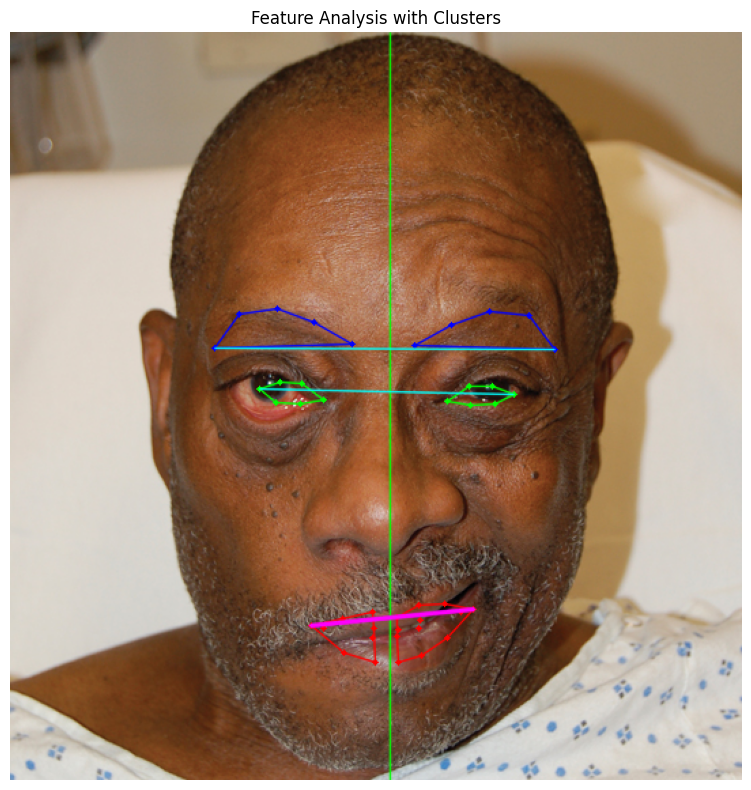

✅ Analysis complete!

FINAL SUMMARY

INTERPRETATION:
  • Significant mouth asymmetry (RIGHT side larger)
  • Mouth angle deviation detected (-5.76°)


In [ ]:
if __name__ == "__main__":
    image_path = input("Enter path to facial image: ").strip().strip('"').strip("'")

    try:
        features, clusters, assignment_summary = analyze_facial_palsy(image_path)
        print("✅ Analysis complete!")

        # Final summary
        print(f"\n{'='*80}")
        print("FINAL SUMMARY")
        print(f"{'='*80}")

        # Interpret results
        print("\nINTERPRETATION:")
        if abs(features['eyebrow_area_diff']) > 50:
            side = "LEFT" if features['eyebrow_area_diff'] > 0 else "RIGHT"
            print(f"  • Significant eyebrow asymmetry ({side} side larger)")

        if abs(features['eye_area_diff']) > 50:
            side = "LEFT" if features['eye_area_diff'] > 0 else "RIGHT"
            print(f"  • Significant eye asymmetry ({side} side larger)")

        if abs(features['mouth_area_diff']) > 50:
            side = "LEFT" if features['mouth_area_diff'] > 0 else "RIGHT"
            print(f"  • Significant mouth asymmetry ({side} side larger)")

        if abs(features['mouth_angle']) > 5:
            print(f"  • Mouth angle deviation detected ({features['mouth_angle']:.2f}°)")

    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()

Enter path to facial image: /content/palsy image.jpg

STEP 2: FACIAL PALSY ANALYSIS

Step 1: Finding midline...
  ✓ Midline X-coordinate: 81.0

Step 2: Analyzing landmark assignment...

LANDMARK ASSIGNMENT ANALYSIS
Midline X-coordinate: 81.0
--------------------------------------------------------------------------------
Index  X        Y        Side     Feature      Assignment          
--------------------------------------------------------------------------------
0      12.0     46.0     left     jawline      left_jawline        
1      12.0     66.0     left     jawline      left_jawline        
2      15.0     84.0     left     jawline      left_jawline        
3      19.0     102.0    left     jawline      left_jawline        
4      25.0     119.0    left     jawline      left_jawline        
5      36.0     133.0    left     jawline      left_jawline        
6      48.0     144.0    left     jawline      left_jawline        
7      63.0     151.0    left     jawline      left_

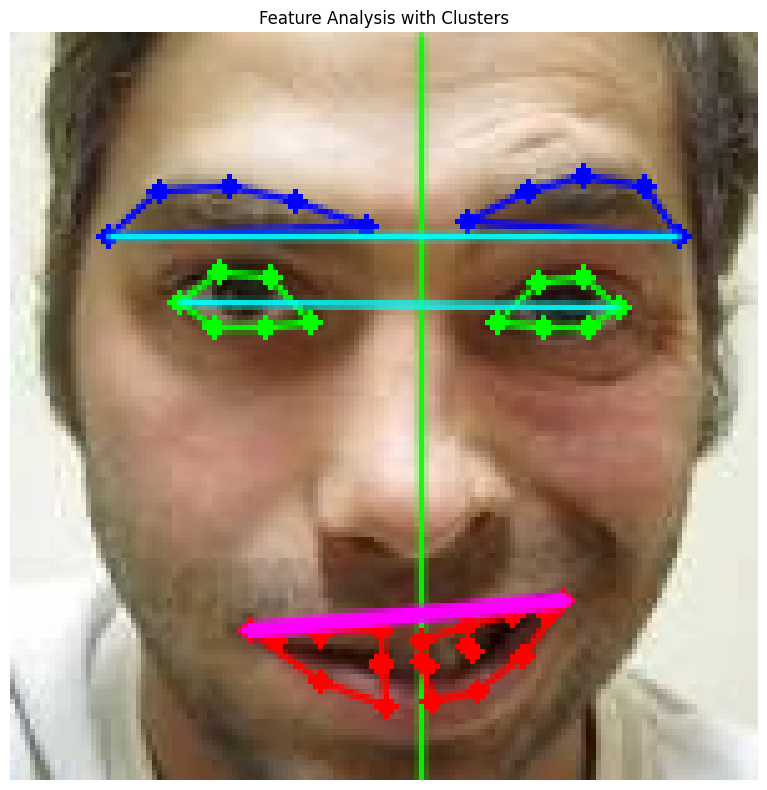

✅ Analysis complete!

FINAL SUMMARY

INTERPRETATION:
  • Mouth angle deviation detected (-5.53°)


In [ ]:
if __name__ == "__main__":
    image_path = input("Enter path to facial image: ").strip().strip('"').strip("'")

    try:
        features, clusters, assignment_summary = analyze_facial_palsy(image_path)
        print("✅ Analysis complete!")

        # Final summary
        print(f"\n{'='*80}")
        print("FINAL SUMMARY")
        print(f"{'='*80}")

        # Interpret results
        print("\nINTERPRETATION:")
        if abs(features['eyebrow_area_diff']) > 50:
            side = "LEFT" if features['eyebrow_area_diff'] > 0 else "RIGHT"
            print(f"  • Significant eyebrow asymmetry ({side} side larger)")

        if abs(features['eye_area_diff']) > 50:
            side = "LEFT" if features['eye_area_diff'] > 0 else "RIGHT"
            print(f"  • Significant eye asymmetry ({side} side larger)")

        if abs(features['mouth_area_diff']) > 50:
            side = "LEFT" if features['mouth_area_diff'] > 0 else "RIGHT"
            print(f"  • Significant mouth asymmetry ({side} side larger)")

        if abs(features['mouth_angle']) > 5:
            print(f"  • Mouth angle deviation detected ({features['mouth_angle']:.2f}°)")

    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()


STEP 1: MODEL DOWNLOAD & SETUP
✅ Models loaded successfully

Enter path to facial image: /content/normal.png

STEP 2: FACIAL ANGLE ANALYSIS

Step 1: Extracting facial landmarks...
  ✓ Found 68 landmarks
  ✓ Midline X-coordinate: 167.0

Step 2: Creating feature clusters...
  ✓ left_eyebrow: 5 points
  ✓ right_eyebrow: 5 points
  ✓ left_eye: 6 points
  ✓ right_eye: 6 points
  ✓ left_mouth: 8 points
  ✓ right_mouth: 12 points

Step 3: Calculating angles...

ANGLE MEASUREMENTS

ANGLES (0° = horizontal):
  Eyebrow:    -0.76°
  Eye:        -0.50°
  Mouth:      -1.76°

Creating visualization...


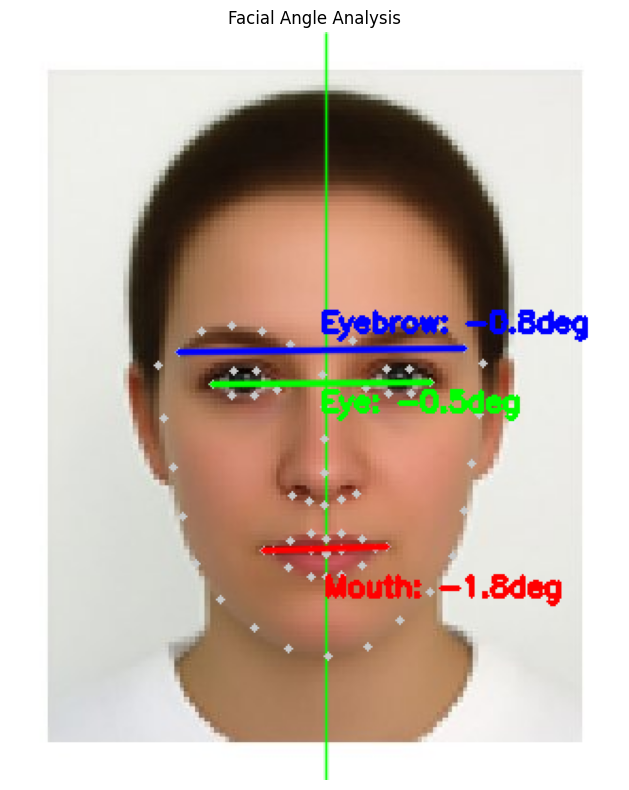

✅ Analysis complete!

FINAL SUMMARY

INTERPRETATION:
  • All angles within normal range (±5°)
  • No significant facial asymmetry detected


In [ ]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
import os
import urllib.request
import bz2

# ============================================================================
# STEP 1: MODEL DOWNLOAD & SETUP
# ============================================================================

print("\n" + "="*80)
print("STEP 1: MODEL DOWNLOAD & SETUP")
print("="*80)

FACE_PROTO = "deploy.prototxt"
FACE_MODEL = "res10_300x300_ssd_iter_140000.caffemodel"

if not os.path.exists(FACE_PROTO):
    print("📥 Downloading face detection model...")
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt",
        FACE_PROTO
    )

if not os.path.exists(FACE_MODEL):
    print("📥 Downloading face detection weights...")
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel",
        FACE_MODEL
    )

LANDMARK_MODEL = "shape_predictor_68_face_landmarks.dat"
if not os.path.exists(LANDMARK_MODEL):
    print("📥 Downloading facial landmark model...")
    urllib.request.urlretrieve(
        "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2",
        "shape_predictor_68_face_landmarks.dat.bz2"
    )
    print("🔧 Extracting landmark model...")
    with bz2.open("shape_predictor_68_face_landmarks.dat.bz2") as f:
        with open(LANDMARK_MODEL, 'wb') as out:
            out.write(f.read())

face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
landmark_predictor = dlib.shape_predictor(LANDMARK_MODEL)
print("✅ Models loaded successfully\n")

# ============================================================================
# FACIAL PALSY ANGLE DETECTION
# ============================================================================

def detect_face_dnn(image, confidence_threshold=0.5):
    """Detect face using OpenCV DNN"""
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
                                  (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype(int)
            return dlib.rectangle(int(x1), int(y1), int(x2), int(y2))

    raise ValueError("No face detected with sufficient confidence")

def get_landmarks(image):
    """Extract 68 facial landmarks from image"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect face using DNN
    face = detect_face_dnn(image)

    # Get landmarks
    shape = landmark_predictor(gray, face)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])

    return landmarks, face

def find_midline(landmarks):
    """Find vertical midline of face"""
    # Use nose tip and chin for midline
    nose_tip = landmarks[30]
    chin = landmarks[8]
    midline_x = (nose_tip[0] + chin[0]) / 2
    return midline_x

def create_clusters(landmarks, midline_x):
    """
    Create 6 clusters: left/right for eyebrows, eyes, mouth
    Uses both landmark position (for left/right) and landmark index (for feature type)
    """
    clusters = {
        'left_eyebrow': [],
        'right_eyebrow': [],
        'left_eye': [],
        'right_eye': [],
        'left_mouth': [],
        'right_mouth': []
    }

    # Assign each landmark to the appropriate cluster
    for i, point in enumerate(landmarks):
        x, y = point

        # Determine feature type based on landmark index
        if 17 <= i <= 26:  # Eyebrow points (17-26)
            if x < midline_x:  # Left of midline
                clusters['left_eyebrow'].append(point)
            else:  # Right of midline
                clusters['right_eyebrow'].append(point)

        elif 36 <= i <= 47:  # Eye points (36-47)
            if x < midline_x:  # Left of midline
                clusters['left_eye'].append(point)
            else:  # Right of midline
                clusters['right_eye'].append(point)

        elif 48 <= i <= 67:  # Mouth points (48-67)
            if x < midline_x:  # Left of midline
                clusters['left_mouth'].append(point)
            else:  # Right of midline
                clusters['right_mouth'].append(point)

    # Convert all lists to numpy arrays
    for cluster_name in clusters:
        clusters[cluster_name] = np.array(clusters[cluster_name])

    return clusters

def get_line_angle(start_point, end_point):
    """Calculate angle of line in degrees (0° = horizontal)"""
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    angle = np.degrees(np.arctan2(dy, dx))
    return angle

def extract_angle_features(clusters, landmarks):
    """
    Extract only 3 angle features:
    - eyebrow_angle: angle of line connecting left and right eyebrow outer points
    - eye_angle: angle of line connecting left and right eye outer corners
    - mouth_angle: angle of line connecting left and right mouth corners
    """
    features = {}

    # Eyebrow angle: left outer to right outer
    eyebrow_left = clusters['left_eyebrow'][0] if len(clusters['left_eyebrow']) > 0 else landmarks[17]
    eyebrow_right = clusters['right_eyebrow'][-1] if len(clusters['right_eyebrow']) > 0 else landmarks[26]
    features['eyebrow_angle'] = get_line_angle(eyebrow_left, eyebrow_right)

    # Eye angle: left outer corner to right outer corner
    eye_left = clusters['left_eye'][0] if len(clusters['left_eye']) > 0 else landmarks[36]
    eye_right = clusters['right_eye'][3] if len(clusters['right_eye']) > 0 else landmarks[45]
    features['eye_angle'] = get_line_angle(eye_left, eye_right)

    # Mouth angle: single line from left corner to right corner
    mouth_left_corner = landmarks[48]  # Left corner of mouth
    mouth_right_corner = landmarks[54]  # Right corner of mouth
    features['mouth_angle'] = get_line_angle(mouth_left_corner, mouth_right_corner)

    return features

def visualize_analysis(image, landmarks, clusters, features, midline_x):
    """
    Visualize the analysis with angle lines
    """
    vis_img = image.copy()
    height, width = vis_img.shape[:2]

    # Draw midline
    cv2.line(vis_img, (int(midline_x), 0), (int(midline_x), height),
             (0, 255, 0), 1, cv2.LINE_AA)

    # Draw all landmarks as small dots
    for point in landmarks:
        cv2.circle(vis_img, tuple(point.astype(int)), 2, (200, 200, 200), -1)

    # Draw angle lines with labels
    # Eyebrow line (Blue)
    eyebrow_left = clusters['left_eyebrow'][0] if len(clusters['left_eyebrow']) > 0 else landmarks[17]
    eyebrow_right = clusters['right_eyebrow'][-1] if len(clusters['right_eyebrow']) > 0 else landmarks[26]
    cv2.line(vis_img, tuple(eyebrow_left.astype(int)),
             tuple(eyebrow_right.astype(int)), (255, 0, 0), 2, cv2.LINE_AA)
    mid_eyebrow = ((eyebrow_left + eyebrow_right) / 2).astype(int)
    cv2.putText(vis_img, f"Eyebrow: {features['eyebrow_angle']:.1f}deg",
                tuple(mid_eyebrow + [0, -10]),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Eye line (Green)
    eye_left = clusters['left_eye'][0] if len(clusters['left_eye']) > 0 else landmarks[36]
    eye_right = clusters['right_eye'][3] if len(clusters['right_eye']) > 0 else landmarks[45]
    cv2.line(vis_img, tuple(eye_left.astype(int)),
             tuple(eye_right.astype(int)), (0, 255, 0), 2, cv2.LINE_AA)
    mid_eye = ((eye_left + eye_right) / 2).astype(int)
    cv2.putText(vis_img, f"Eye: {features['eye_angle']:.1f}deg",
                tuple(mid_eye + [0, 15]),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Mouth line (Red)
    mouth_left_corner = landmarks[48]
    mouth_right_corner = landmarks[54]
    cv2.line(vis_img, tuple(mouth_left_corner.astype(int)),
             tuple(mouth_right_corner.astype(int)), (0, 0, 255), 2, cv2.LINE_AA)
    mid_mouth = ((mouth_left_corner + mouth_right_corner) / 2).astype(int)
    cv2.putText(vis_img, f"Mouth: {features['mouth_angle']:.1f}deg",
                tuple(mid_mouth + [0, 25]),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    return vis_img

def analyze_facial_palsy(image_path):
    """
    Main analysis function for angle measurements
    """
    print(f"\n{'='*80}")
    print(f"STEP 2: FACIAL ANGLE ANALYSIS")
    print(f"{'='*80}\n")

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")

    # Step 1: Get landmarks and find midline
    print("Step 1: Extracting facial landmarks...")
    landmarks, face = get_landmarks(image)
    midline_x = find_midline(landmarks)
    print(f"  ✓ Found {len(landmarks)} landmarks")
    print(f"  ✓ Midline X-coordinate: {midline_x:.1f}")

    # Step 2: Create clusters
    print("\nStep 2: Creating feature clusters...")
    clusters = create_clusters(landmarks, midline_x)

    # Verify cluster counts
    for cluster_name, points in clusters.items():
        print(f"  ✓ {cluster_name}: {len(points)} points")

    # Step 3: Extract angle features only
    print("\nStep 3: Calculating angles...")
    features = extract_angle_features(clusters, landmarks)

    # Display results
    print(f"\n{'='*80}")
    print("ANGLE MEASUREMENTS")
    print(f"{'='*80}")

    print("\nANGLES (0° = horizontal):")
    print(f"  Eyebrow: {features['eyebrow_angle']:>8.2f}°")
    print(f"  Eye:     {features['eye_angle']:>8.2f}°")
    print(f"  Mouth:   {features['mouth_angle']:>8.2f}°")

    # Create visualization
    print("\nCreating visualization...")
    vis_img = visualize_analysis(image, landmarks, clusters, features, midline_x)

    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.title('Facial Angle Analysis')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return features, clusters

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    image_path = input("Enter path to facial image: ").strip().strip('"').strip("'")

    try:
        features, clusters = analyze_facial_palsy(image_path)
        print("✅ Analysis complete!")

        # Final summary
        print(f"\n{'='*80}")
        print("FINAL SUMMARY")
        print(f"{'='*80}")

        # Interpret results - ANGLES ONLY
        print("\nINTERPRETATION:")

        deviation_found = False

        if abs(features['eyebrow_angle']) > 5:
            direction = "upward" if features['eyebrow_angle'] > 0 else "downward"
            print(f"  • Eyebrow line deviation detected ({features['eyebrow_angle']:.2f}°, tilted {direction})")
            deviation_found = True

        if abs(features['eye_angle']) > 5:
            direction = "upward" if features['eye_angle'] > 0 else "downward"
            print(f"  • Eye line deviation detected ({features['eye_angle']:.2f}°, tilted {direction})")
            deviation_found = True

        if abs(features['mouth_angle']) > 5:
            direction = "upward" if features['mouth_angle'] > 0 else "downward"
            print(f"  • Mouth angle deviation detected ({features['mouth_angle']:.2f}°, tilted {direction})")
            deviation_found = True

        if not deviation_found:
            print(f"  • All angles within normal range (±5°)")
            print(f"  • No significant facial asymmetry detected")

    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()